In [196]:
# Import libraries

import sys
import re
import requests
import json
import asyncio
import nest_asyncio
import aiohttp
import time
import warnings
from datetime import datetime
from dateutil.relativedelta import relativedelta

# Suppress unnecessary Shapely warning
warnings.filterwarnings('ignore',
                        '.*Shapely GEOS version.*')

from aiohttp import ClientSession
from requests import request, Session
from itertools import product, repeat
import os
from dotenv import load_dotenv
from os import getenv
from threading import Thread
import time
import inspect
import pandas as pd
import geopandas as gp
import shapely
import pygeos
from functools import reduce
from pandas.plotting import lag_plot
import pickle
import numpy as np
import seaborn as sns
import datetime as dt
import copy
import math
from decimal import Decimal
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
from matplotlib.gridspec import GridSpec
from matplotlib.offsetbox import AnchoredText
import matplotlib as mpl
import plotly.express as px
from sklearn.metrics import mean_absolute_error
from multiprocess import Process, Pool

from sklearn.linear_model import LinearRegression, Ridge

# Set up Pandas defaults
pd.options.display.float_format = '{:.6f}'.format
pd.set_option("display.max_columns", None)



### Analyze Job Growth

In [543]:
# Read in most recent job data
jobs = pd.read_csv('datasets/bls/raw/most_recent_bls_data.csv',
                   dtype={'msa_code':str, 'state_code':str})

# Make sure the date column is in datetime format
jobs['date'] = pd.to_datetime(jobs['date'])

# Replace NECTA Division
jobs['msa_name'] = jobs['msa_name'].apply(lambda x: x.replace(" NECTA Division",""))
jobs['msa_name'] = jobs['msa_name'].apply(lambda x: x.replace(" NECTA",""))

jobs

,msa_code,msa_name,state_code,year,month,date,value,series_id
0,10180,"Abilene, TX",48,2022,November,2022-11-01,73500.000000,SMS48101800000000001
1,10180,"Abilene, TX",48,2022,October,2022-10-01,73600.000000,SMS48101800000000001
2,10180,"Abilene, TX",48,2022,September,2022-09-01,73600.000000,SMS48101800000000001
3,10180,"Abilene, TX",48,2022,August,2022-08-01,74300.000000,SMS48101800000000001
4,10180,"Abilene, TX",48,2022,July,2022-07-01,74200.000000,SMS48101800000000001
...,...,...,...,...,...,...,...,...
46405,49740,"Yuma, AZ",04,2013,May,2013-05-01,51800.000000,SMS04497400000000001
46406,49740,"Yuma, AZ",04,2013,April,2013-04-01,51600.000000,SMS04497400000000001
46407,49740,"Yuma, AZ",04,2013,March,2013-03-01,51900.000000,SMS04497400000000001
46408,49740,"Yuma, AZ",04,2013,February,2013-02-01,52000.000000,SMS04497400000000001


In [34]:
# Isolate MSAs by state

# Get Texas MSAs
texas_df = jobs[jobs['state_code']=='48'].copy()

texas_df

,msa_code,msa_name,state_code,year,month,date,value,series_id
0,10180,"Abilene, TX",48,2022,November,2022-11-01,73500.00,SMS48101800000000001
1,10180,"Abilene, TX",48,2022,October,2022-10-01,73600.00,SMS48101800000000001
2,10180,"Abilene, TX",48,2022,September,2022-09-01,73600.00,SMS48101800000000001
3,10180,"Abilene, TX",48,2022,August,2022-08-01,74300.00,SMS48101800000000001
4,10180,"Abilene, TX",48,2022,July,2022-07-01,74200.00,SMS48101800000000001
...,...,...,...,...,...,...,...,...
45215,48660,"Wichita Falls, TX",48,2013,May,2013-05-01,58000.00,SMS48486600000000001
45216,48660,"Wichita Falls, TX",48,2013,April,2013-04-01,57900.00,SMS48486600000000001
45217,48660,"Wichita Falls, TX",48,2013,March,2013-03-01,57800.00,SMS48486600000000001
45218,48660,"Wichita Falls, TX",48,2013,February,2013-02-01,57700.00,SMS48486600000000001


In [578]:
texas_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2975 entries, 0 to 45219
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   msa_code    2975 non-null   object        
 1   msa_name    2975 non-null   object        
 2   state_code  2975 non-null   object        
 3   year        2975 non-null   int64         
 4   month       2975 non-null   object        
 5   date        2975 non-null   datetime64[ns]
 6   value       2975 non-null   float64       
 7   series_id   2975 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 209.2+ KB


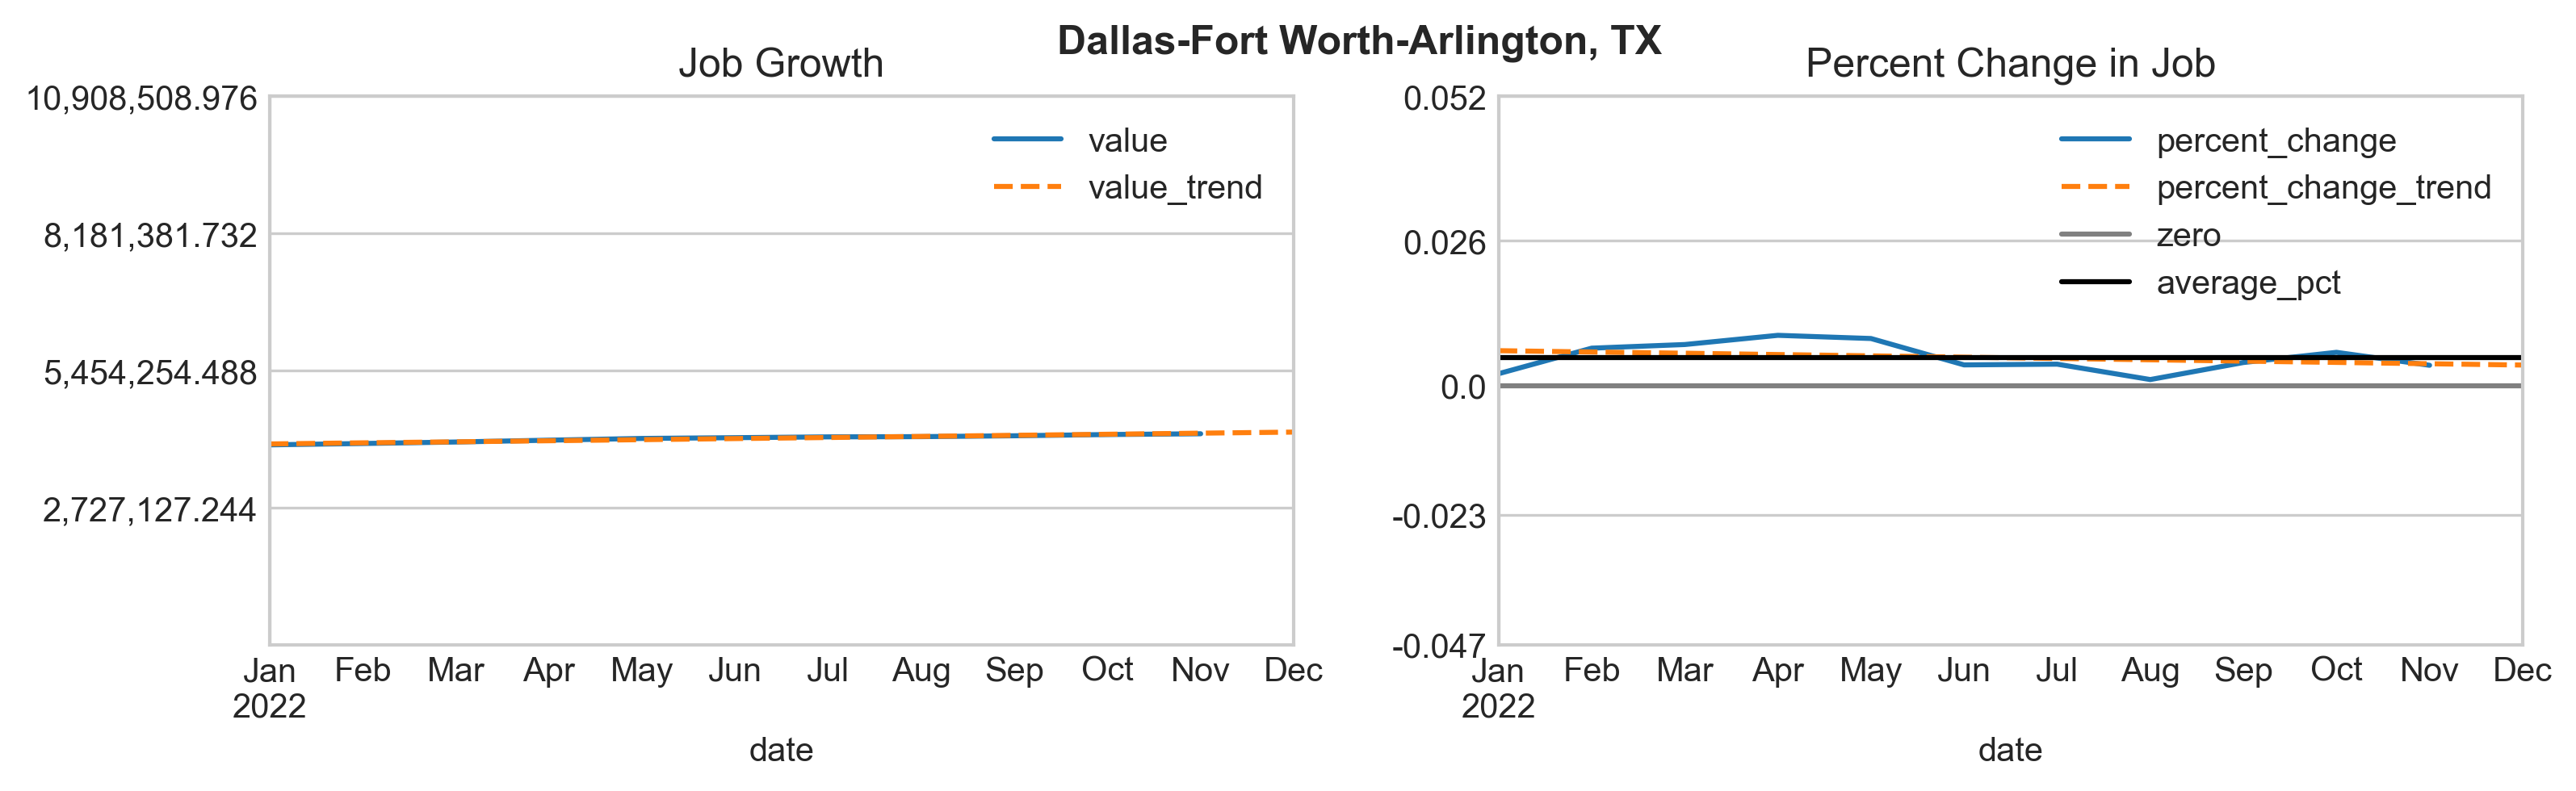

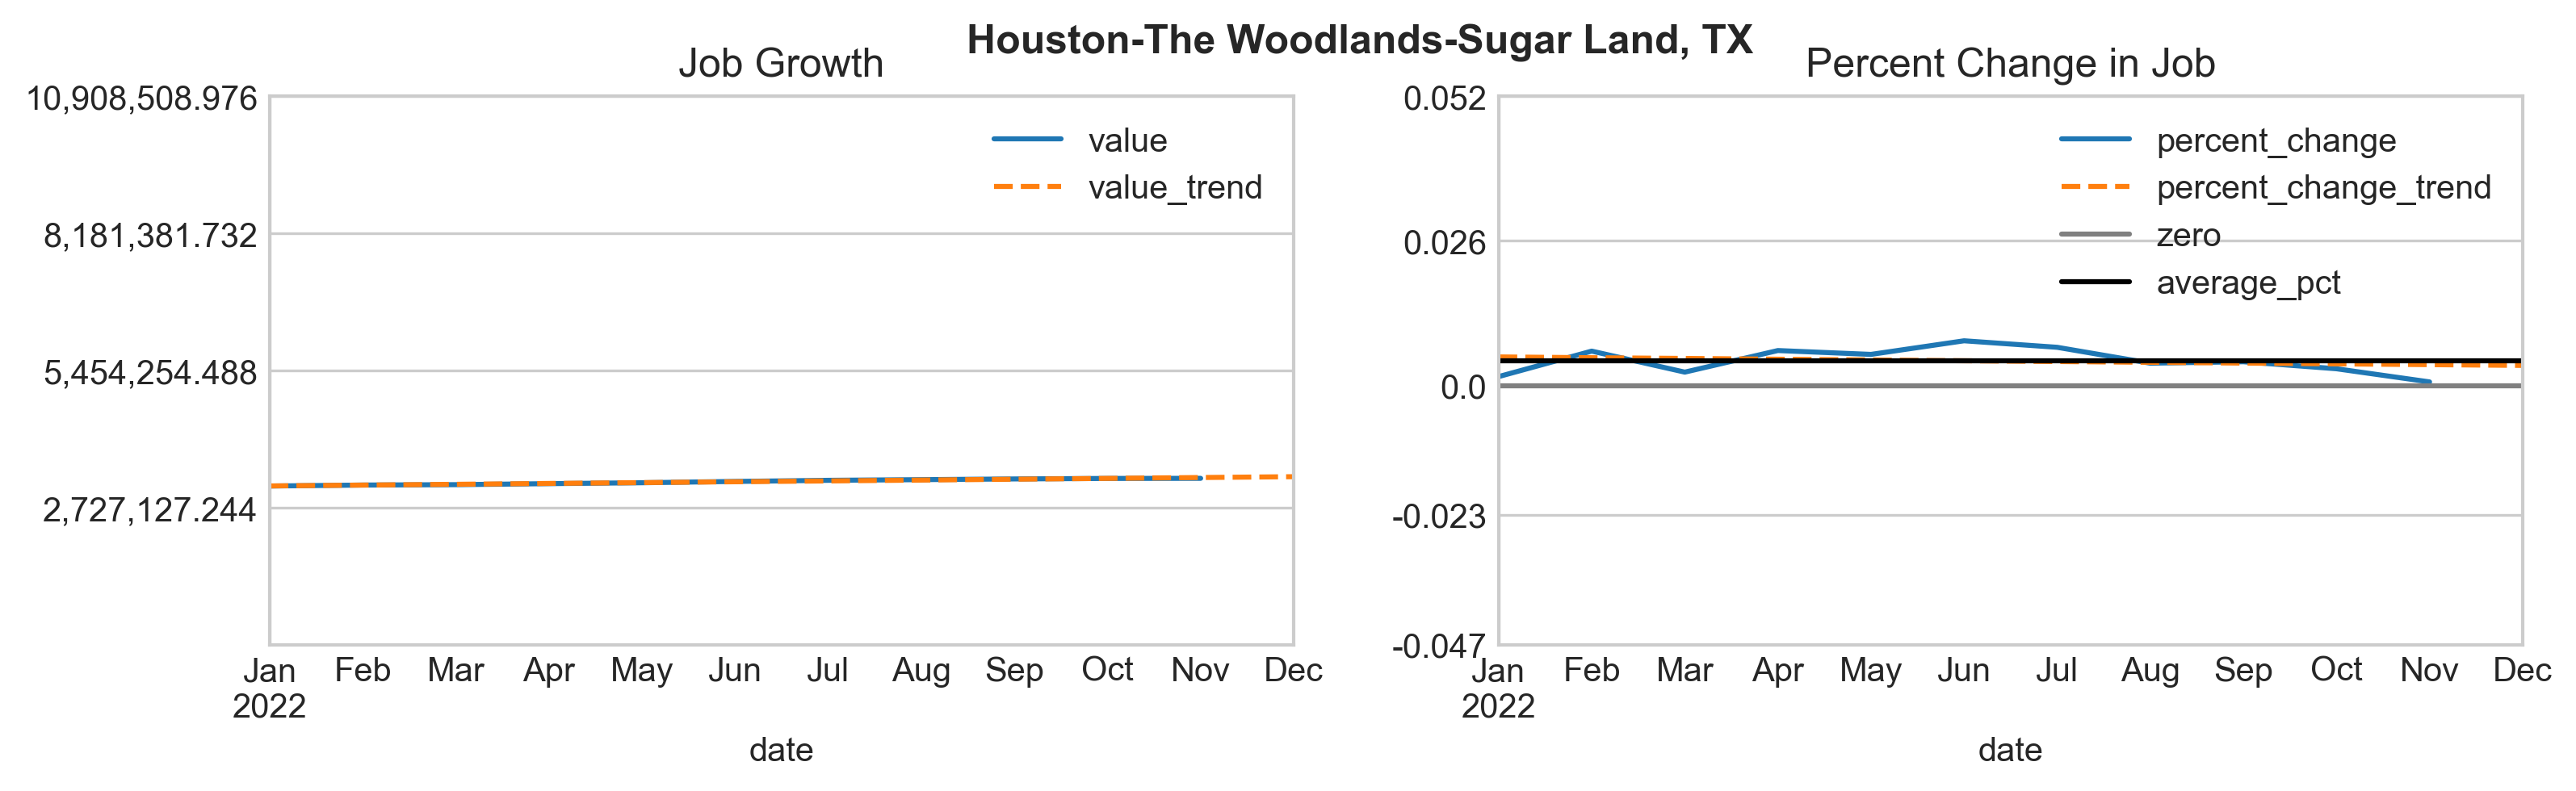

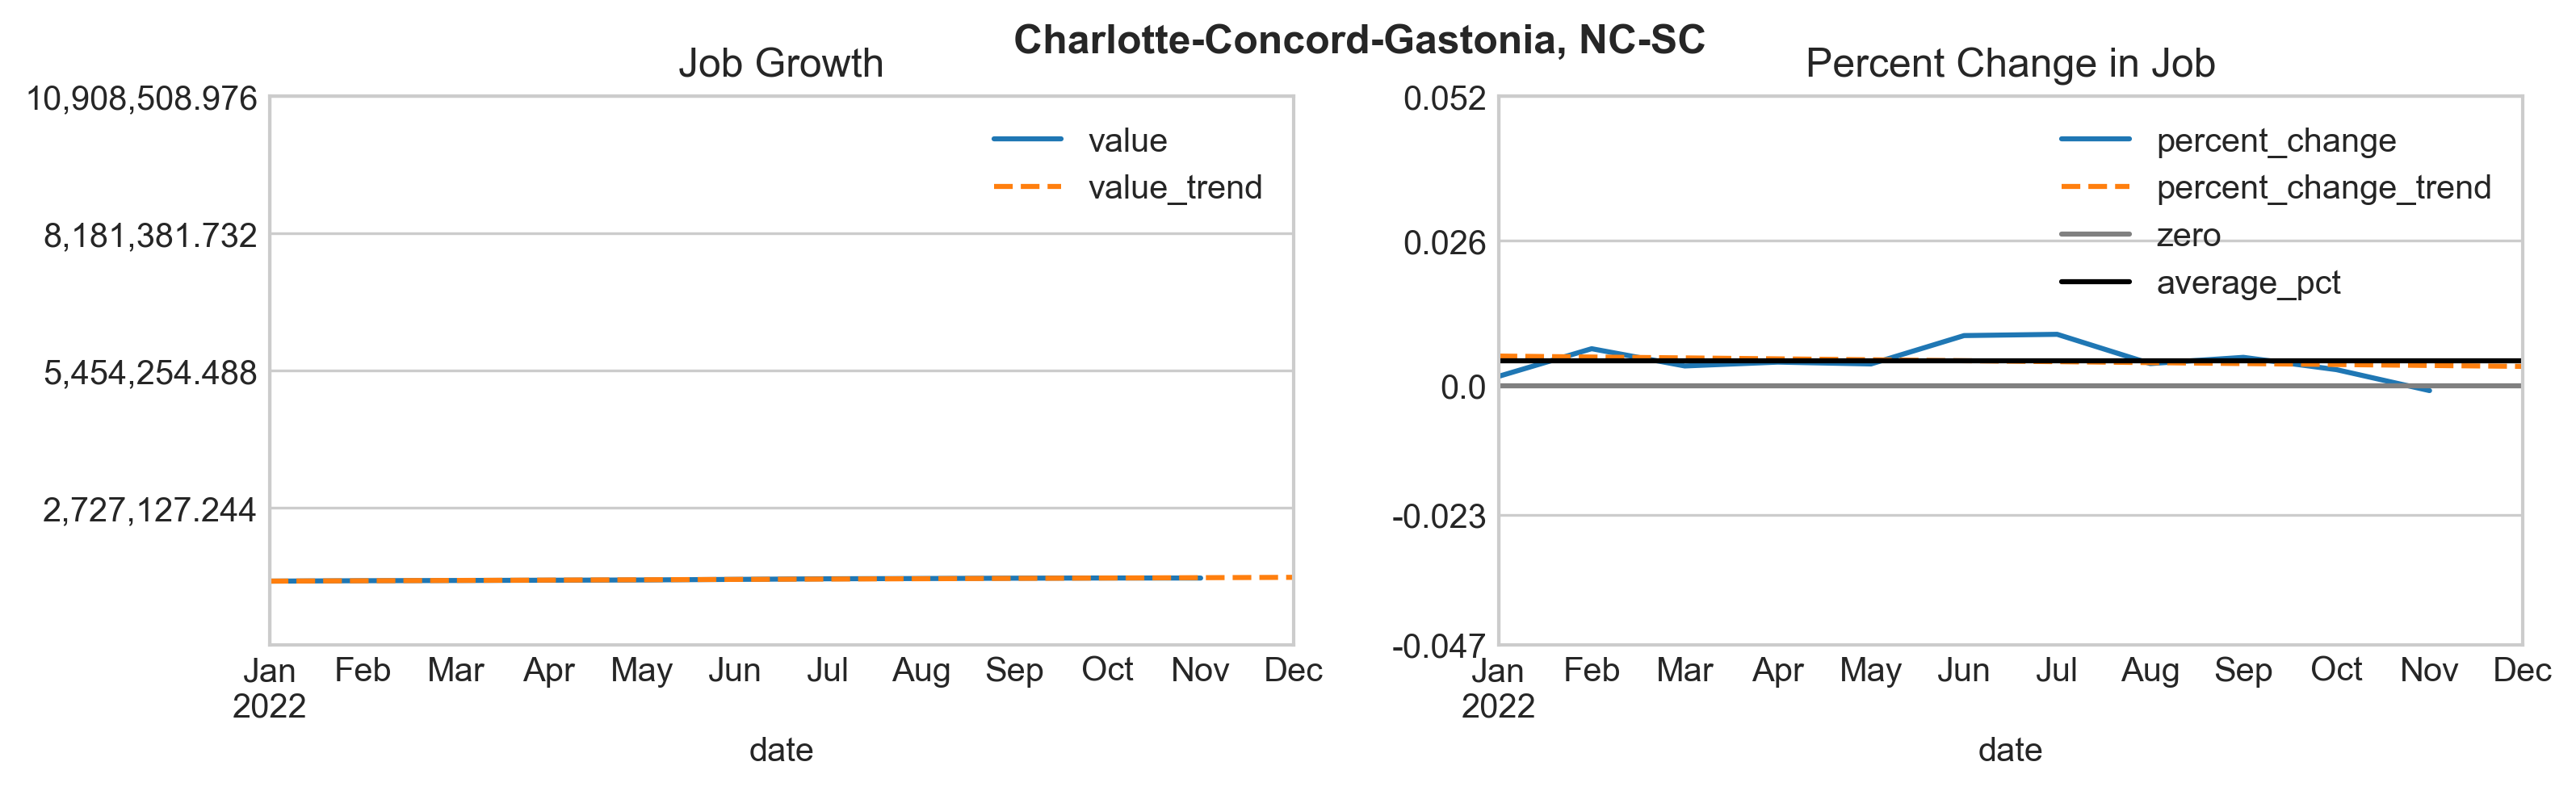

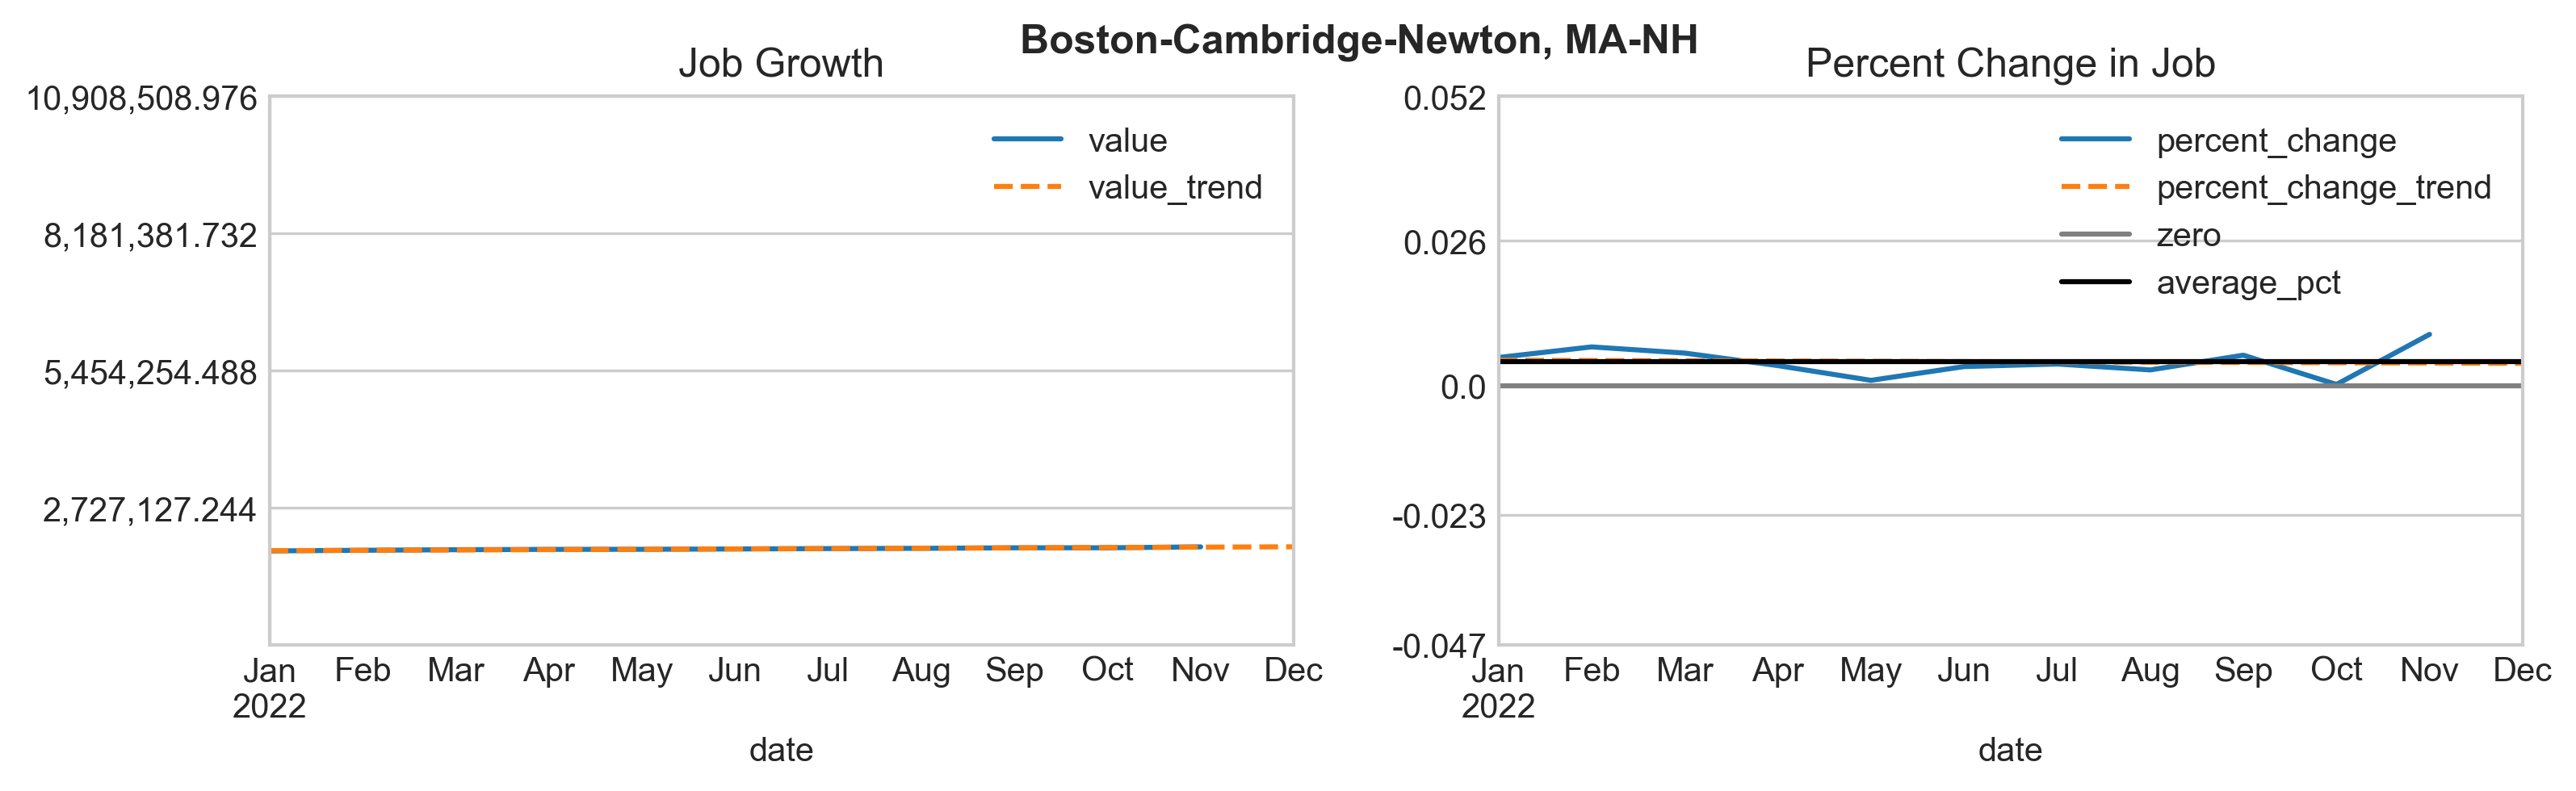

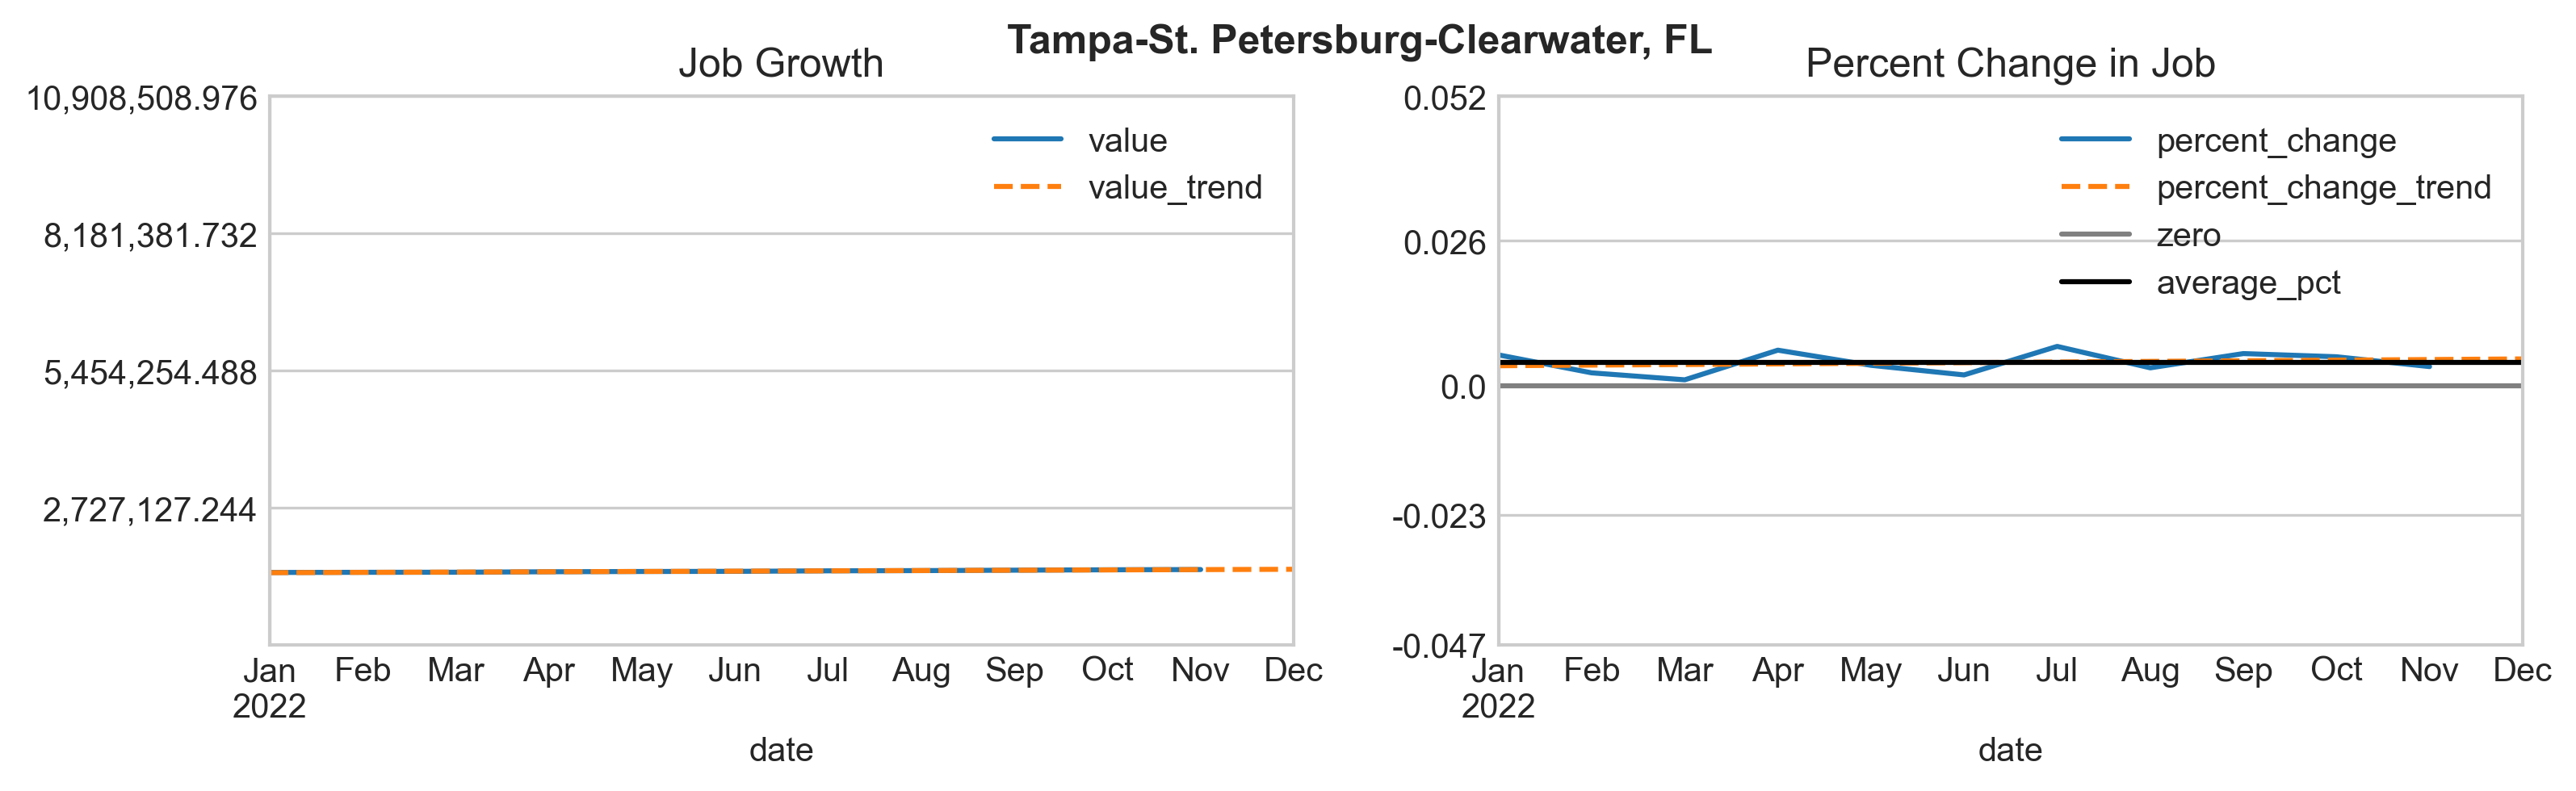

,city,msa_code,trend_coef,average_value,average_pct,average_pct_rank,trend_coef_rank,total_rank
0,"Dallas-Fort Worth-Arlington, TX",19100,704.550272,20818.181818,0.005119,2,1,3
1,"Houston-The Woodlands-Sugar Land, TX",26420,550.441836,14400.000000,0.004472,7,3,10
2,"Charlotte-Concord-Gastonia, NC-SC",16740,225.012109,5772.727273,0.004476,6,11,17
3,"Boston-Cambridge-Newton, MA-NH",71654,231.180930,8181.818182,0.004318,9,10,19
4,"Tampa-St. Petersburg-Clearwater, FL",45300,201.515774,6027.272727,0.004133,13,13,26
...,...,...,...,...,...,...,...,...
378,"Michigan City-La Porte, IN",33140,-2.175669,-45.454545,-0.001118,380,368,748
379,"Monroe, MI",33780,-3.118593,-27.272727,-0.000674,375,375,750
380,"Yuba City, CA",49700,-2.904914,-45.454545,-0.000922,379,373,752
381,"Racine, WI",39540,-5.020707,-36.363636,-0.000459,372,381,753


In [546]:
# Loop through all cities, sort by coefficient, plot top 5
def plot_top_5_job_cities(
    dataframe_1,
    begin_year_1=2013,
    plot_all=False,
    plot_pct_change=False,
    sort_by_avg_pct_growth_and_total_trend=False,
    demographic_1="Job",
    use_multiple_demographics=False,
    dataframe_dict=None
):
    """
    Plots the top cities for a given demographic. Top cities
    are chosen based on their trend. This function can also 
    find the top cities based on multiple datasets.
    
    Arguments
    ----------
        dataframe_1 (DataFrame): The main dataframe used
            for plotting. Below is an example of the
            columns used and their dtypes of a dataframe
            used in this function...
            
            Column      Dtype
            --------    --------
            msa_code    object        
            msa_name    object        
            state_code  object        
            year        int64         
            date        datetime64[ns]
            value       float64
            
        begin_year_1 (int): The year you'd like the
            analysis to start.
            
        plot_all (True/False): True if you want to plot every
            city in the dataframe (slow). False if you only want
            to plot the top 5 (fast).
            
        plot_pct_change (True/False): True if you only want
            to plot the percent change in the demographic over
            time.
            
        sort_by_avg_pct_growth_and_total_trend (True/False):
            If True, sort and plot by average percentage growth 
            and total trend.
            
        demographic_1 (str): A string of the name of the
            demographic, such as "Job" or "Median Rent".
            
        use_multiple_demographics (True/False): True if you want
            to combine multiple dataframes for analysis and
            plotting.
            
        dataframe_dict (dict): A dictionary to be used if you
            want to combine multiple dataframes for analysis
            and plotting. If using this, the key should be
            a string with the demographic name, and the value
            should be a list containing the dataframe in position
            0, and the beginning year in position 1. See below
            for two examples...
            
            Example 1, One Extra Dataframe
            {"Median Rent": [median_rent_df, 2013]}
            
            Example 2, Multiple Extra Dataframes
            {"Median Rent": [median_rent_df, 2013],
            "Population" : [population_df, 2013]}
    
    Returns
    ----------
        coef_df (DataFrame): A dataframe with the rankings
            of each city, from "best to worst."
    
    """
    
    # Make copy
    main_df = dataframe_1.copy()
    
    # Drop all Puerto Rico rows
    main_df = main_df[main_df['state_code']!='72'].reset_index(drop=True)
        
    # Create main variable to use for the rest of the script
    if plot_pct_change:
        column = 'percent_change'
    elif sort_by_avg_pct_growth_and_total_trend:
        column = 'value'
    else:
        column = 'value'

    # Create new df to store job coefficients
    coef_df = pd.DataFrame(
        data=None, columns=['city','msa_code',
                            'trend_coef','average_value','average_pct'])

    # Create dictionary to store filtered dataframes
    filtered_dict = {}

    # Set y_lim list to find max and min
    y_lim_list_trend = []
    y_min_list_trend = [0]
    y_lim_list_pct = []
    y_min_list_pct = [0]
    
    # Loop through all cities
    for city in main_df['msa_name'].dropna().unique():

        # Isolate just that city
        df = main_df[main_df['msa_name']==city].copy()
        
        # Get msa_code
        msa_code = df['msa_code'].iloc[0]
        
        # Sort by date
        df = df.sort_values('date')
        
        # Create difference column
        df['value_change'] = df['value'].diff()
        
        # Create pct_change column
        df['percent_change'] = df['value'].pct_change()
        
        # Filter by beginning year
        df = df[df['year']>=begin_year_1].reset_index(drop=True)
        
        # If an MSA's most recent year is after the beginning
        # year, remove it from the graphs. For example, if we want to
        # view the growth of all cities since 2016, but Prescott Valley
        # only has data starting at 2019, this may skew the data.
        if df['year'].iloc[0] != begin_year_1:
            print(f"Dropping {city}, it's dataframe has a smaller window.")
            display(df)
            continue
                
        # Remove NaN values
        df = df[df['percent_change'].notna()]

        # Isolate date and value columns
        df = df[[
            'date', 'value', 'value_change',
            'percent_change']].reset_index(drop=True)
        
        # Add this dataframe's y_lim to list
        if sort_by_avg_pct_growth_and_total_trend:
            y_lim_list_trend.append(df['value'].max())
            y_min_list_trend.append(df['value'].min())
            y_lim_list_pct.append(df['percent_change'].max())
            y_min_list_pct.append(df['percent_change'].min())
        else:
            y_lim_list_trend.append(df[column].max())
            y_min_list_trend.append(df[column].min())

        if plot_pct_change:
            # get next months's datetime
            next_year = df['date'].iloc[-1] + relativedelta(months=1)
        elif sort_by_avg_pct_growth_and_total_trend:
            # get next months's datetime
            next_year = df['date'].iloc[-1] + relativedelta(months=1)
        else:
            # get next year's datetime
            next_year = df['date'].iloc[-1] + relativedelta(months=6)

        # Create ordinal column
        df['ordinal_date'] = df['date'].map(datetime.toordinal)
        
        # Testing
        #display(df)

        def run_lr(df, column):
            """Run linear regression and return coefficient."""
            # Run linear regression
            normal_lr = LinearRegression()
            X = df[['ordinal_date']]
            y = df[column]
            normal_lr.fit(X, y)
            coef = normal_lr.coef_[0]
            intercept = normal_lr.intercept_
            
            # Return lr coefficient
            return coef, intercept
        
        # Run linear regression and get the trend's coefficient
        if sort_by_avg_pct_growth_and_total_trend:
            coef_value, intercept_value = run_lr(df, column='value')
            coef_pct, intercept_pct = run_lr(df, column='percent_change')
        else:
            coef, intercept = run_lr(df, column=column)

        # Create next year's date
        df.loc[len(df.index)] = [
            next_year, np.nan, np.nan, np.nan, datetime.toordinal(next_year)]
        
        # Create averages column
        the_average_pct = df['percent_change'].mean()
        df['average_pct'] = the_average_pct
        the_average_value = df['value_change'].mean()
        df['average_value'] = the_average_value

        # Fill in with linear regression values.
        # Also add highest trend value to lim_list.
        if sort_by_avg_pct_growth_and_total_trend:
            df['value_trend'] = df['ordinal_date']*coef_value + intercept_value
            df['percent_change_trend'] = df['ordinal_date']*coef_pct + intercept_pct
            
            # Also add highest trend value to lim_list
            y_lim_list_trend.append(df['value_trend'].max())
            y_lim_list_pct.append(df['percent_change_trend'].max())
                        
            # Add coef to dataframe
            coef_df.loc[len(coef_df.index)] = [city, msa_code, coef_value, 
                                               the_average_value, 
                                               the_average_pct]
            
            # Get the y_lim
            y_lim_trend = max(y_lim_list_trend) * 1.1
            y_min_trend = min(y_min_list_trend)
            y_lim_pct = max(y_lim_list_pct) * 1.1
            y_min_pct = min(y_min_list_pct)
            
        else:
            df['trend'] = df['ordinal_date']*coef + intercept
        
            # Also add highest trend value to lim_list
            y_lim_list_trend.append(df['trend'].max())
            
            # Add coef to dataframe
            coef_df.loc[len(coef_df.index)] = [city, msa_code, coef, 
                                               the_average_value, 
                                               the_average_pct]
            
            # Get the y_lim
            y_lim = max(y_lim_list_trend) * 1.1
            y_min = min(y_min_list_trend)

        # Save filtered data to dictionary
        filtered_dict[city] = df

    # If plotting percent-change, sort by average
    if plot_pct_change:
        coef_df = coef_df.sort_values(
            'average_pct', ascending=False).reset_index(drop=True)
        
    # Else if sorting by average percent change 
    # AND total trend (coefficient)...
    elif sort_by_avg_pct_growth_and_total_trend:
        
        # Calculate rankings for both, then sort by the total
        # ranking. For example, if a city has the highest average
        # percent change, it will get a ranking of "1" for average_pct,
        # and if it has the 8th highest trend coefficient, it will
        # get a ranking of "8" for trend_coef. When we add those two
        # rankings together, the city will have a total ranking
        # of "9". In this case, the lower the ranking, the better,
        # and we will sort total rankings from lowest to highest.
        
        # Calculate average_pct ranking
        coef_df = coef_df.sort_values(
            'average_pct', ascending=False).reset_index(drop=True)
        coef_df['average_pct_rank'] = coef_df.index
        
        # Calculate trend_coef ranking
        coef_df = coef_df.sort_values(
            'trend_coef', ascending=False).reset_index(drop=True)
        coef_df['trend_coef_rank'] = coef_df.index
        
        # Create total ranking
        coef_df['total_rank'] = coef_df['average_pct_rank'] + coef_df['trend_coef_rank']
        
        # Sort by total rank, lowest to highest
        coef_df = coef_df.sort_values(
            'total_rank', ascending=True).reset_index(drop=True)
        
    # Otherwise, sort by coefficient
    else:
        coef_df = coef_df.sort_values(
            'trend_coef', ascending=False).reset_index(drop=True)
    
    
    # If plot_all=True, plot all
    if plot_all:
        the_range = len(main_df['msa_name'].dropna().unique())
    else:
        the_range = 5
    
    # Loop through top 5
    for i in range(the_range):

        # Get city name
        city_name = coef_df['city'].iloc[i]

        # Get the job data
        df = filtered_dict[city_name]
        
        # If not plotting both, only plot one
        if not sort_by_avg_pct_growth_and_total_trend:

            # Plot the results
            fig, ax = plt.subplots(figsize=(8,4))
            df.plot(x='date',y=column, ax=ax)
            df.plot(x='date',y='trend', ax=ax, linestyle="--")
            plt.title(city_name)

            # If plotting pct_change, plot the zero line
            if plot_pct_change:
                df['zero'] = 0
                df.plot(x='date', y='zero', ax=ax, color="grey")

                # Also plot the average line
                df.plot(x='date', y='average_pct', ax=ax, color="black", linestyle="-")

                # Also print the job growth rate coefficient and average
                get_coef = coef_df[coef_df['city']==city_name]['trend_coef'].iloc[0]
                print(f"{city_name} Job Growth Rate per Month: {get_coef}")
                print(f"{city_name} Average Job Growth per Month: {df[column].mean()}")

            # Set y range
            ax.set_ylim([y_min,y_lim])

            # Set y_ticks
            if y_min >= 0:
                y_tick_list = [y_lim*0.25, y_lim*0.5, y_lim*0.75, y_lim]
            else:
                y_tick_list = [y_min, y_min*0.5, 0, y_lim*0.5, y_lim]
            ax.yaxis.set_major_locator(mticker.FixedLocator(y_tick_list))
            ax.set_yticklabels(['{:,}'.format(round(float(x), 3)) for x in y_tick_list])
            
        elif sort_by_avg_pct_growth_and_total_trend:
            
            # Make a grid to plot 2 graphs on
            fig = plt.figure(figsize=(12,3), dpi=300)
            gs = GridSpec(nrows=1, ncols=2)
            ax1 = fig.add_subplot(gs[0,0])
            ax2 = fig.add_subplot(gs[0,1])
            ax_list = [ax1, ax2]
            
            # Set title
            fig.suptitle(f"{city_name}\n\n\n", 
                 fontweight="bold")
            
            # Plot first graph
            ax1 = df.plot(x='date',y='value', ax=ax1)
            ax1 = df.plot(x='date',y='value_trend', ax=ax1, linestyle="--")
            
            # Plot second graph
            ax2 = df.plot(x='date',y='percent_change', ax=ax2)
            ax2 = df.plot(x='date',y='percent_change_trend', ax=ax2, linestyle="--")
            
            # Second graph's zero line
            df['zero'] = 0
            ax2 = df.plot(x='date', y='zero', ax=ax2, color="grey")

            # Also plot the average line
            ax2 = df.plot(x='date', y='average_pct', 
                          ax=ax2, color="black", linestyle="-")
            
            # Set title's for both graphs
            ax1.set_title(f"{demographic_1} Growth")
            ax2.set_title(f"Percent Change in {demographic_1}")
            
            # Set y lims and y ticks
            ax1.set_ylim([y_min_trend, y_lim_trend])
            ax2.set_ylim([y_min_pct, y_lim_pct])
            
            # Set y limits
            y_tick_list_trend = [
                y_lim_trend*0.25, y_lim_trend*0.5, 
                y_lim_trend*0.75, y_lim_trend]
            y_tick_list_pct = [
                y_min_pct, y_min_pct*0.5, 0, 
                y_lim_pct*0.5, y_lim_pct]

            # Set y_ticks
            ax1.yaxis.set_major_locator(
                mticker.FixedLocator(y_tick_list_trend))
            ax2.yaxis.set_major_locator(
                mticker.FixedLocator(y_tick_list_pct))
            
            # Set y-tick labels
            ax1.set_yticklabels(
                ['{:,}'.format(round(float(x), 3)) for x in y_tick_list_trend])
            ax2.set_yticklabels(
                ['{:,}'.format(round(float(x), 3)) for x in y_tick_list_pct])
            
        # Show plot
        plt.show()
    
    # Display the coefficients
    display(coef_df)
    
    # Return the dataframe
    return coef_df
        
# job_coef = plot_top_5_job_cities(
#     dataframe_1=jobs, sort_by_avg_pct_growth_and_total_trend=True,
#     begin_year_1=2022, demographic_1="Job"
# )

# TESTING BELOW, DELETE WHEN DONE, FINDING
# A WAY TO INCOPORATE MULTIPLE DATAFRAMES
# INTO THE RANKING
job_rent_coef = plot_top_5_job_cities(
    
    # Arguments for 1st dataframe
    dataframe_1=jobs, sort_by_avg_pct_growth_and_total_trend=True,
    begin_year_1=2022, demographic_1="Job",
    
    # Arguments for all other dataframes in the format
    # of a dictionary with the demographic name as the key
    # and a list of [dataframe, begin_year] for the value
    dataframe_dict={"Median Rent":[median_rent, 2013]}
)



In [ ]:
### Now that we've analyzed jobs, we need 
### MSA income, unit price, and rent, 
### so we can analyze:
### 1) rent-to-price ratio, and
### 2) income growth
### And then rank them all

### Then once we have our chosen MSA, 
### we need to rank the entire MSA/County by tract

### Read in: 

1. Median Rent
2. Median Price
3. Rent-to-Price ratio per MSA

In [315]:
# Define last year
end_year = 2021

In [408]:
# Read in state FIPS codes
state_fips = pd.read_csv(
    "datasets/helper_datasets/state_FIPS_codes.csv",
    dtype={'state_code':str}
)

state_fips.head(3)

,state_code,state_abbr
0,01,AL
1,02,AK
2,04,AZ


In [434]:
# Read in MSA state codes
msa_state_fips = pd.read_csv(
    "datasets/helper_datasets/msa_and_state_codes.csv",
    dtype={'FIPS State Code':str, 'CBSA Code':str}
)

# Get only necessary columns
msa_state_fips = msa_state_fips[['CBSA Code','CBSA Title','FIPS State Code']]

# Rename column
msa_state_fips.rename(columns={'FIPS State Code':'state_code'}, inplace=True)

msa_state_fips.head(3)

,CBSA Code,CBSA Title,state_code
0,10180,"Abilene, TX",48
1,10380,"Aguadilla-Isabela, PR",72
2,10420,"Akron, OH",39


In [366]:
# Turn into datetime format
def turn_df_into_datetime(dataframe):
    """
    Turns a dataframe created by the API functions
    into a tidy datetime format.
    """
    # Make a copy
    df = dataframe.copy()
    
    # Set index
    df = df.set_index(['msa_name','msa_code'])
    
    # Stack
    df = df.stack()
    
    # Turn into dataframe
    df = pd.DataFrame(df).reset_index()
    
    # Rename the post-stacked columns
    df.rename(columns={'level_2':'year', 0:'value'}, inplace=True)
    
    # Make year column integer
    df['year'] = df['year'].astype(int)
    
    # Make datetime column
    df['date'] = pd.to_datetime(df['year'], format='%Y')
    
    return df


In [577]:
# Read in median rent
median_rent = pd.read_csv(
    "datasets/cleaned_census_api_files/msa_data/median_rent_msa.csv",
    dtype={'msa_code':str}
)

# Turn into tidy datetime
median_rent = turn_df_into_datetime(median_rent)

# Add MSA state code
median_rent = median_rent.merge(msa_state_fips, 
                                how='left', 
                                left_on=['msa_name','msa_code'],
                                right_on=['CBSA Title','CBSA Code'])

# Drop unnecessary columns
median_rent.drop(columns=['CBSA Title','CBSA Code'], inplace=True)

# Replace NECTA Division
median_rent['msa_name'] = median_rent['msa_name'].apply(lambda x: x.replace(" NECTA Division",""))
median_rent['msa_name'] = median_rent['msa_name'].apply(lambda x: x.replace(" NECTA",""))


median_rent


,msa_name,msa_code,year,value,date,state_code
0,"Abilene, TX",10180,2010,554.000000,2010-01-01,48
1,"Abilene, TX",10180,2011,515.000000,2011-01-01,48
2,"Abilene, TX",10180,2012,572.000000,2012-01-01,48
3,"Abilene, TX",10180,2013,549.000000,2013-01-01,48
4,"Abilene, TX",10180,2014,613.000000,2014-01-01,48
...,...,...,...,...,...,...
4633,"Yuma, AZ",49740,2017,682.000000,2017-01-01,04
4634,"Yuma, AZ",49740,2018,692.000000,2018-01-01,04
4635,"Yuma, AZ",49740,2019,665.000000,2019-01-01,04
4636,"Yuma, AZ",49740,2020,717.500000,2020-01-01,04


In [541]:
# Read in median price
median_price = pd.read_csv(
    "datasets/cleaned_census_api_files/msa_data/median_price_msa.csv",
    dtype={'msa_code':str}
)

# Turn into tidy datetime
median_price = turn_df_into_datetime(median_price)

# Add MSA state code
median_price = median_price.merge(msa_state_fips, 
                                how='left', 
                                left_on=['msa_name','msa_code'],
                                right_on=['CBSA Title','CBSA Code'])

# Drop unnecessary columns
median_price.drop(columns=['CBSA Title','CBSA Code'], inplace=True)

# Replace NECTA Division
median_price['msa_name'] = median_price['msa_name'].apply(lambda x: x.replace(" NECTA Division",""))
median_price['msa_name'] = median_price['msa_name'].apply(lambda x: x.replace(" NECTA",""))


median_price.head(3)

,msa_name,msa_code,year,value,date,state_code
0,"Abilene, TX",10180,2010,90900.000000,2010-01-01,48
1,"Abilene, TX",10180,2011,81900.000000,2011-01-01,48
2,"Abilene, TX",10180,2012,94600.000000,2012-01-01,48


In [542]:
# Read in rent_to_price
rent_to_price = pd.read_csv(
    "datasets/cleaned_census_api_files/msa_data/rent_to_price_ratio_msa.csv",
    dtype={'msa_code':str}
)

# Turn into tidy datetime
rent_to_price = turn_df_into_datetime(rent_to_price)

# Add MSA state code
rent_to_price = rent_to_price.merge(msa_state_fips, 
                                how='left', 
                                left_on=['msa_code'],
                                right_on=['CBSA Code'])

# Drop unnecessary columns
rent_to_price.drop(columns=['CBSA Title','CBSA Code'], inplace=True)

# Replace NECTA Division
rent_to_price['msa_name'] = rent_to_price['msa_name'].apply(lambda x: x.replace(" NECTA Division",""))
rent_to_price['msa_name'] = rent_to_price['msa_name'].apply(lambda x: x.replace(" NECTA",""))


rent_to_price.head(3)

,msa_name,msa_code,year,value,date,state_code
0,"Abilene, TX",10180,2010,0.006095,2010-01-01,48
1,"Abilene, TX",10180,2011,0.006288,2011-01-01,48
2,"Abilene, TX",10180,2012,0.006047,2012-01-01,48


### Plot Rent Growth

Dropping Dayton-Kettering, OH, it's dataframe has a smaller window.


,msa_name,msa_code,year,value,date,state_code,value_change,percent_change
0,"Dayton-Kettering, OH",19430,2019,654.000000,2019-01-01,39,NaN,NaN
1,"Dayton-Kettering, OH",19430,2020,689.500000,2020-01-01,39,35.500000,0.054281
2,"Dayton-Kettering, OH",19430,2021,725.000000,2021-01-01,39,35.500000,0.051487


Dropping Poughkeepsie-Newburgh-Middletown, NY, it's dataframe has a smaller window.


,msa_name,msa_code,year,value,date,state_code,value_change,percent_change
0,"Poughkeepsie-Newburgh-Middletown, NY",39100,2019,1144.000000,2019-01-01,36,201.000000,0.213150
1,"Poughkeepsie-Newburgh-Middletown, NY",39100,2020,1182.000000,2020-01-01,36,38.000000,0.033217
2,"Poughkeepsie-Newburgh-Middletown, NY",39100,2021,1220.000000,2021-01-01,36,38.000000,0.032149


Dropping Prescott Valley-Prescott, AZ, it's dataframe has a smaller window.


,msa_name,msa_code,year,value,date,state_code,value_change,percent_change
0,"Prescott Valley-Prescott, AZ",39150,2019,863.000000,2019-01-01,04,NaN,NaN
1,"Prescott Valley-Prescott, AZ",39150,2020,902.000000,2020-01-01,04,39.000000,0.045191
2,"Prescott Valley-Prescott, AZ",39150,2021,941.000000,2021-01-01,04,39.000000,0.043237


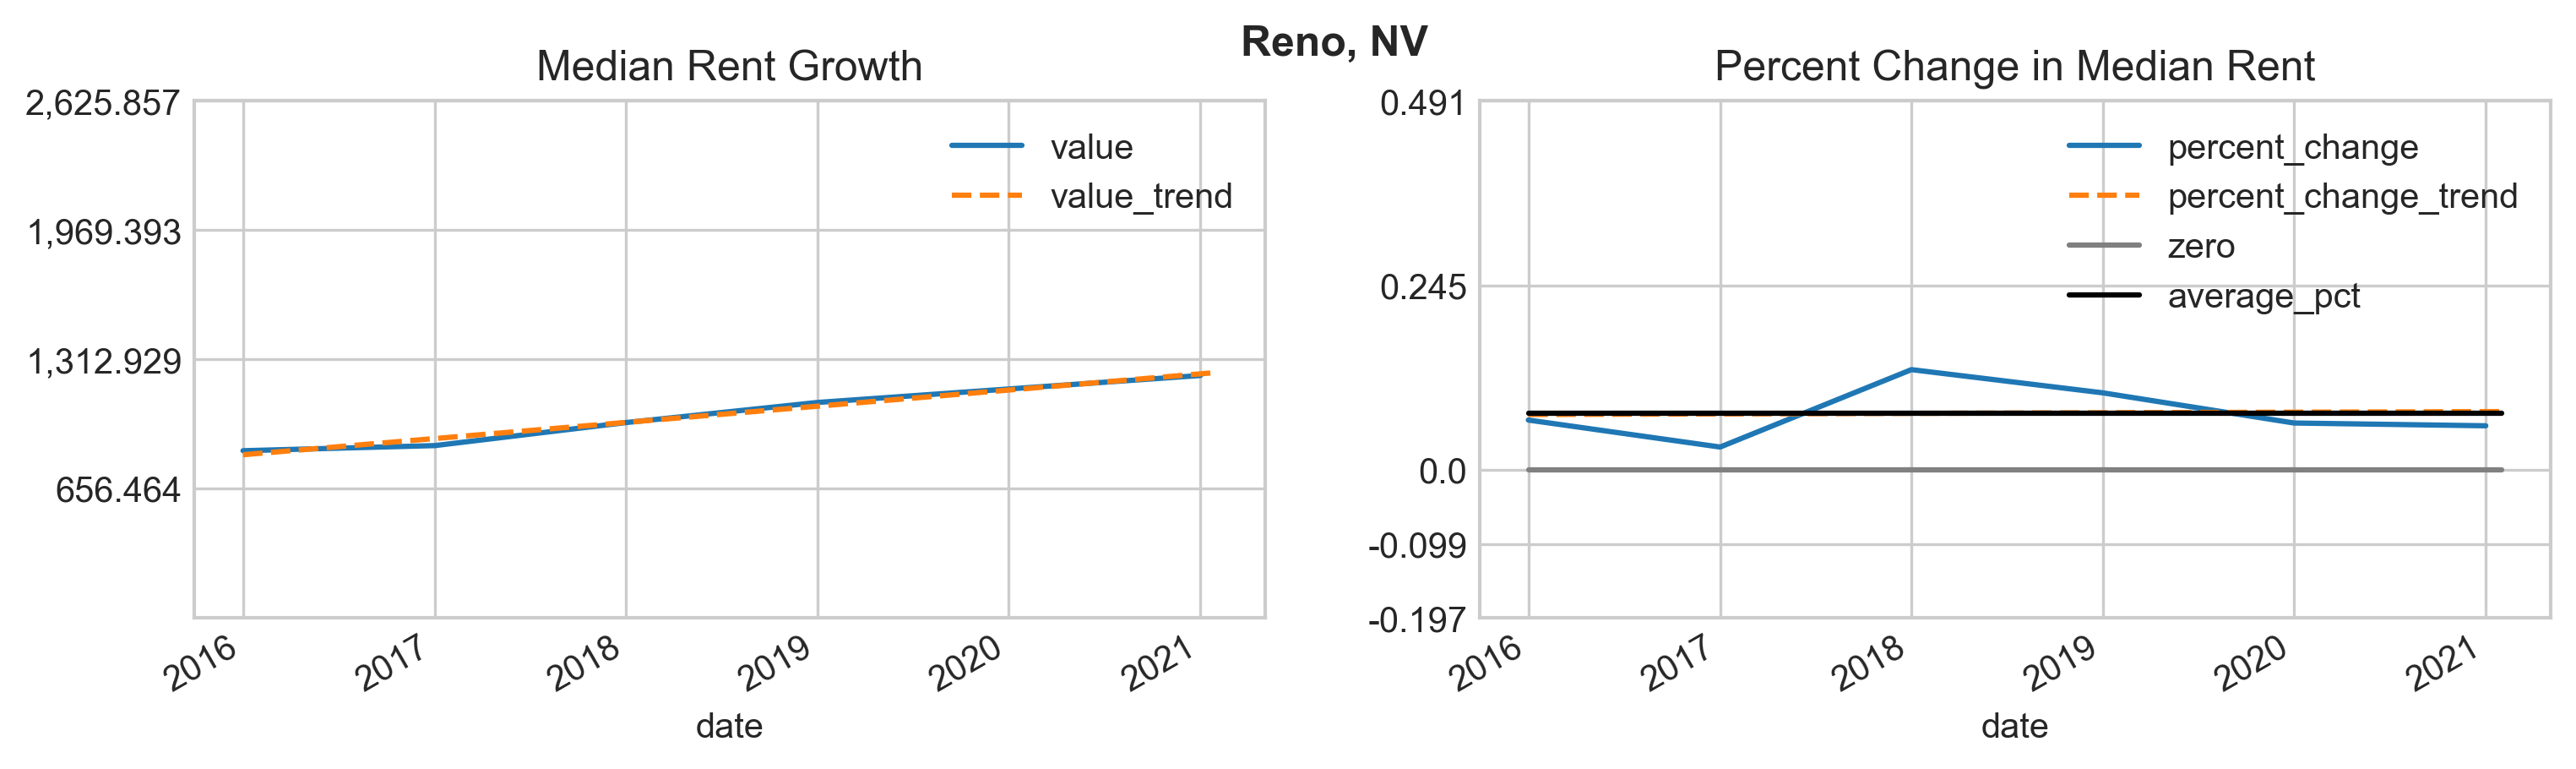

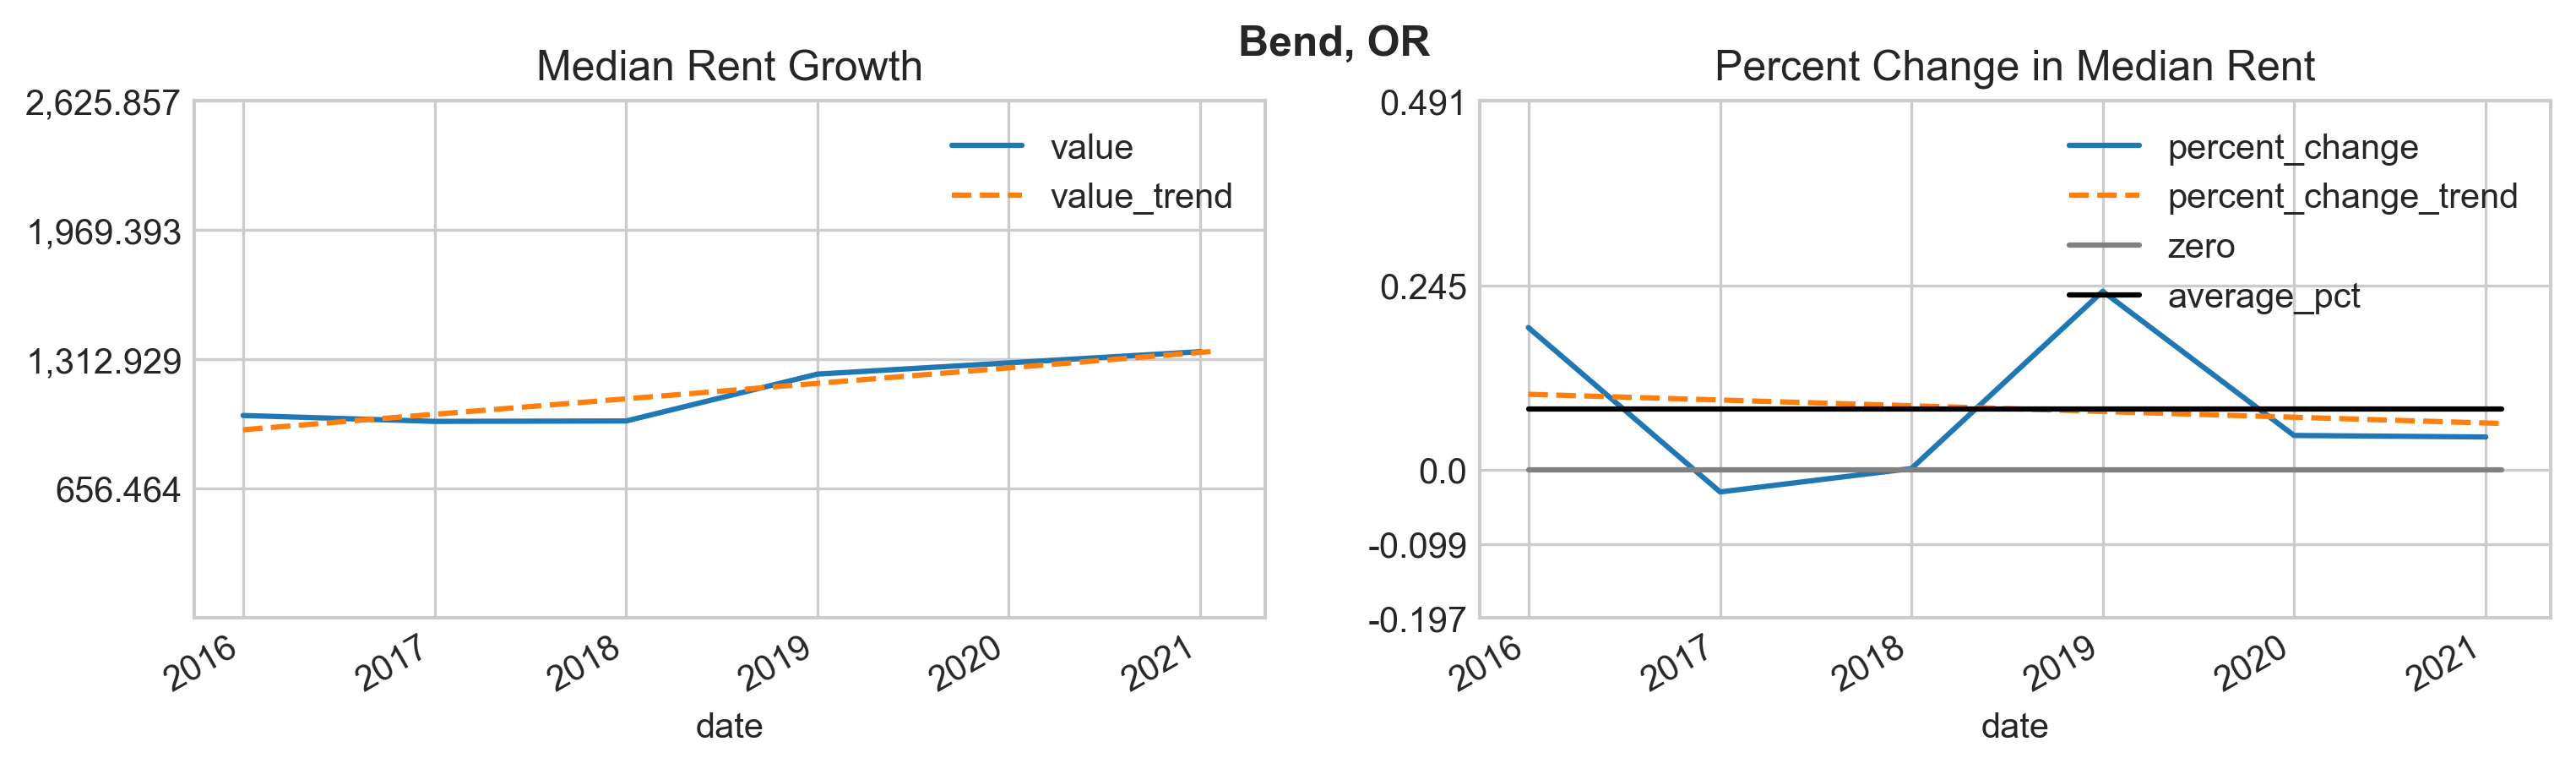

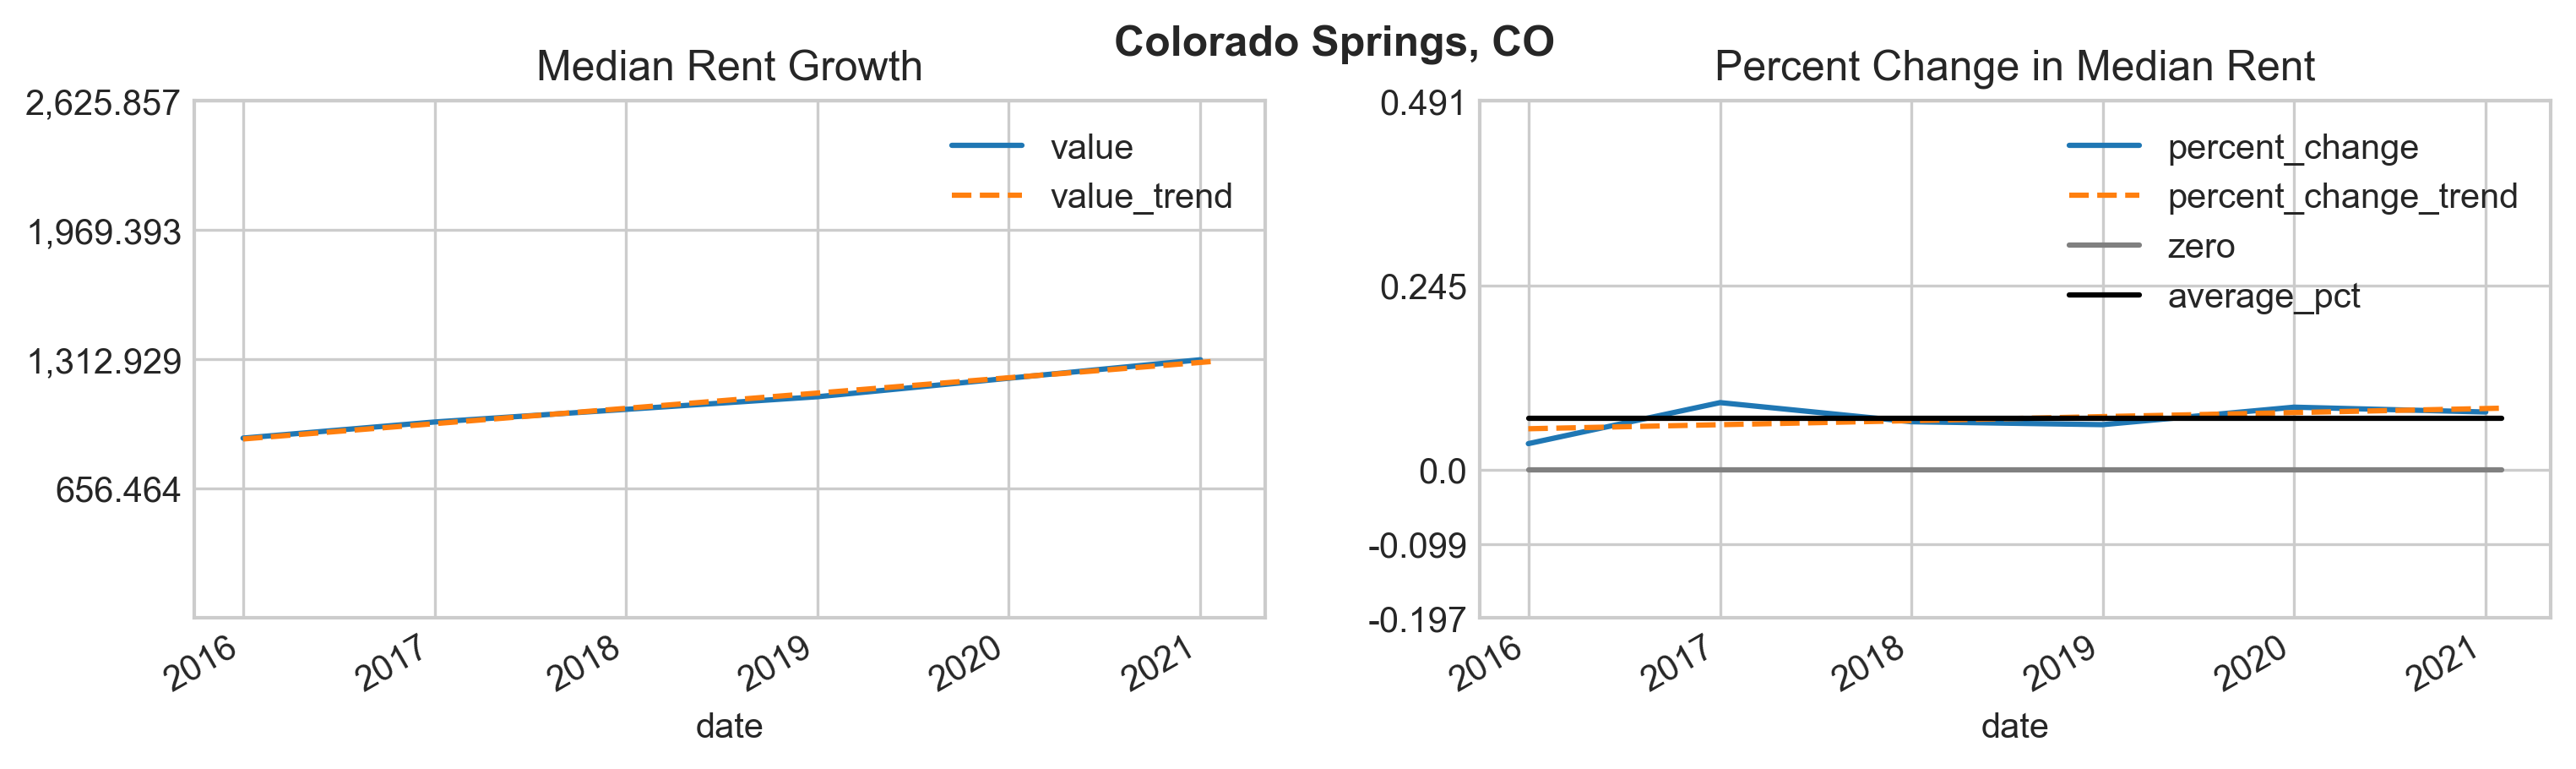

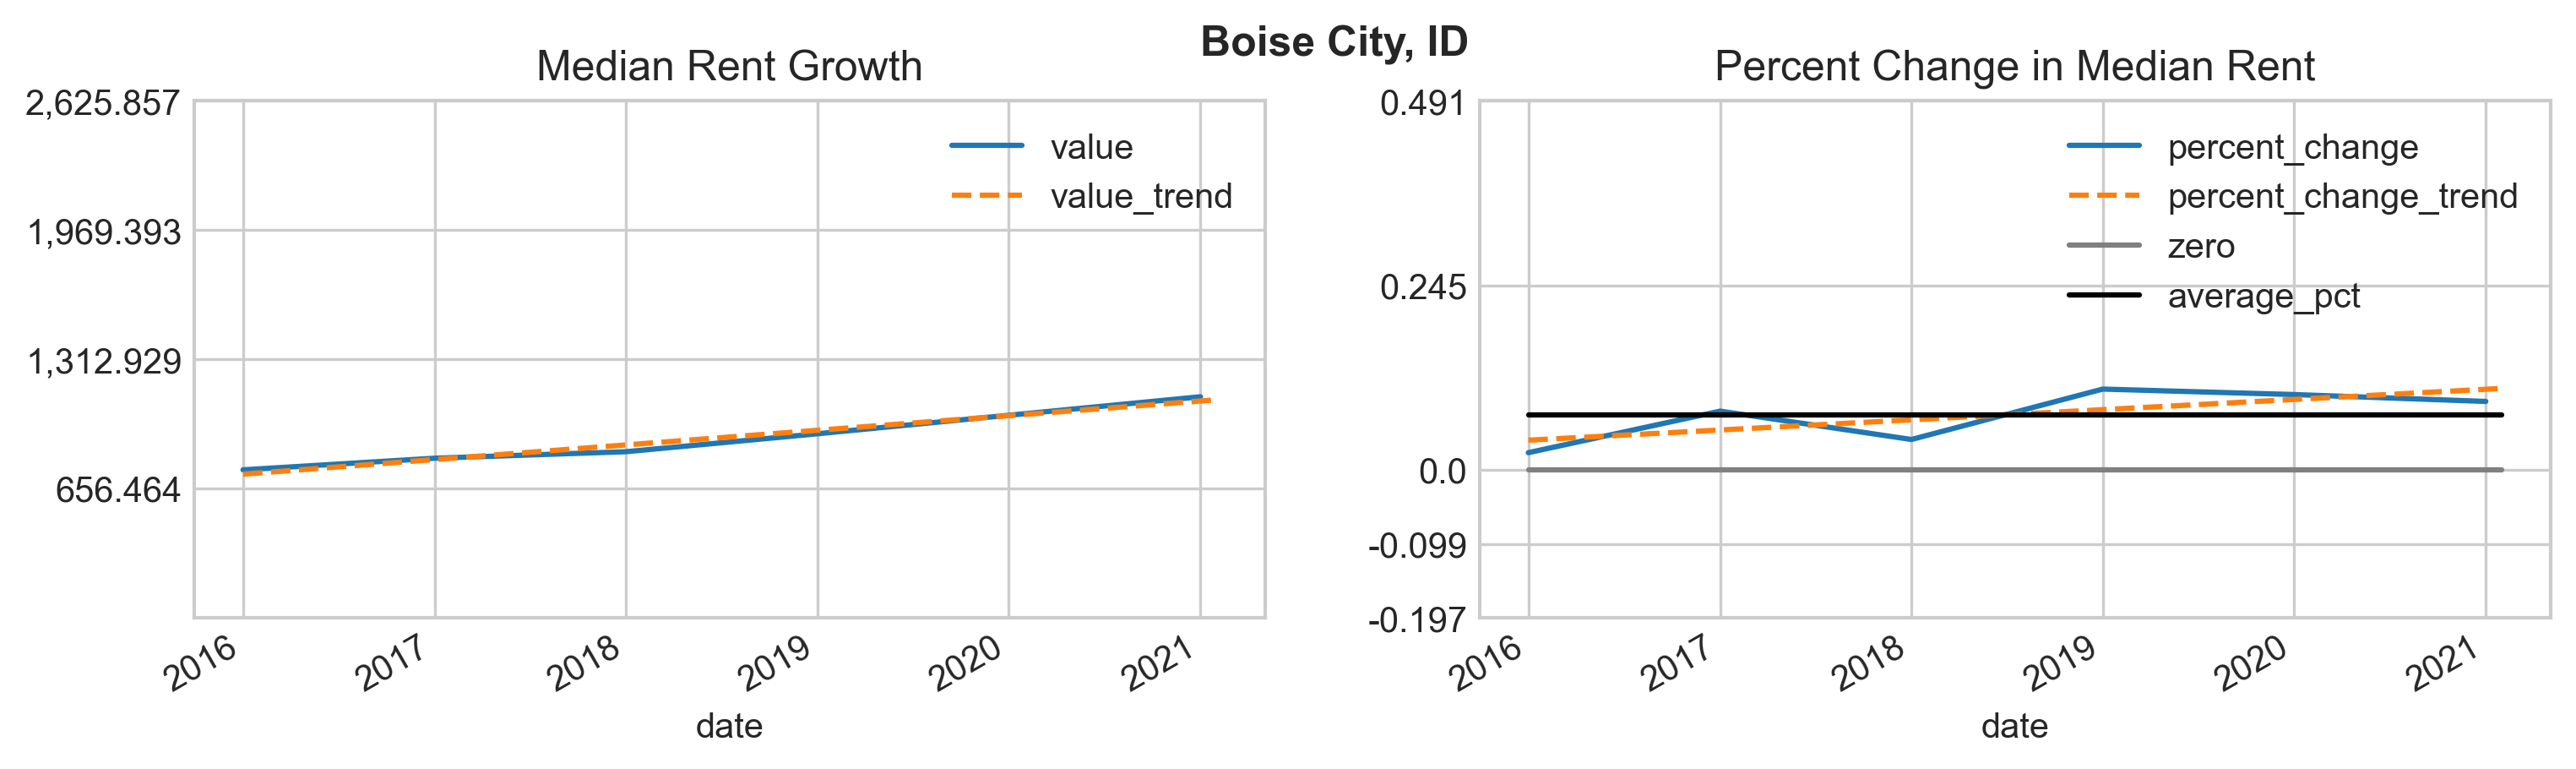

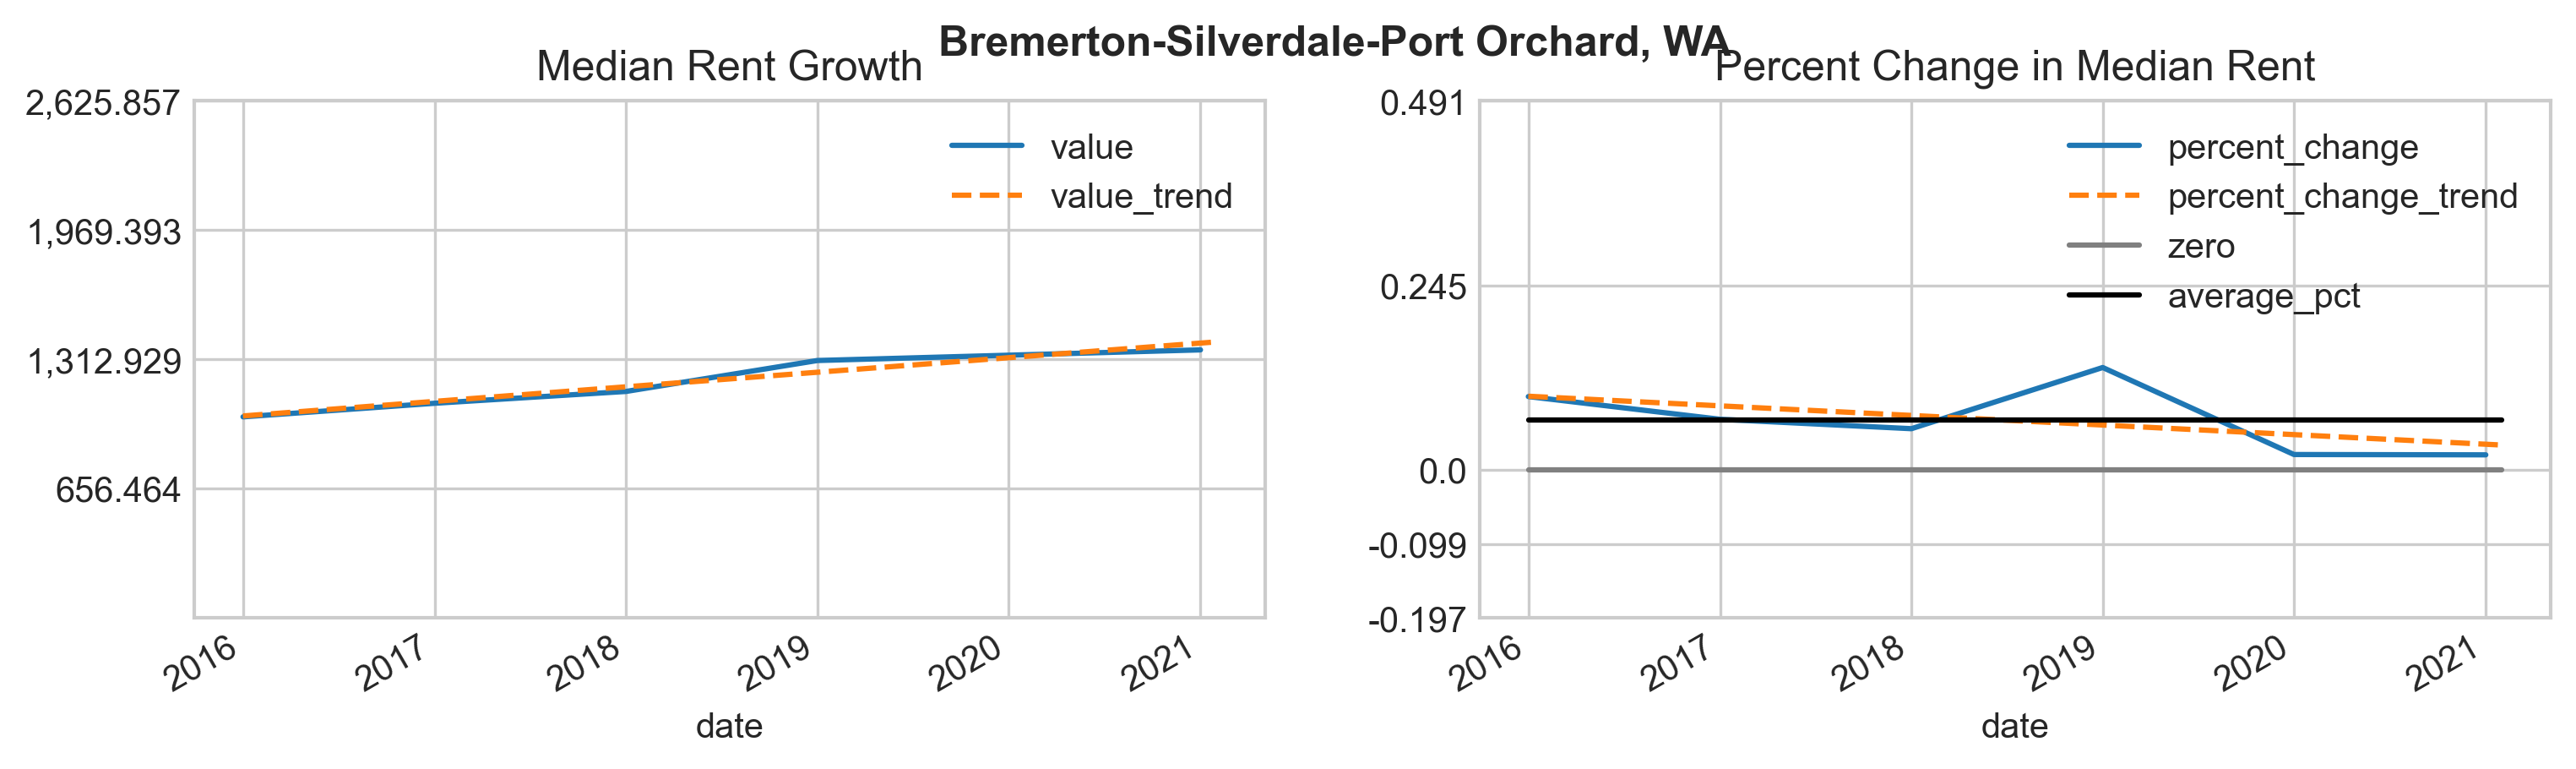

,city,trend_coef,average_value,average_pct,average_pct_rank,trend_coef_rank,total_rank
0,"Reno, NV",0.224821,72.500000,0.075800,2,2,4
1,"Bend, OR",0.214988,81.333333,0.081699,0,4,4
2,"Colorado Springs, CO",0.212753,71.500000,0.068377,4,5,9
3,"Boise City, ID",0.203363,64.666667,0.073579,3,12,15
4,"Bremerton-Silverdale-Port Orchard, WA",0.202490,71.833333,0.066254,5,13,18
...,...,...,...,...,...,...,...
376,"Manhattan, KS",0.002410,-5.500000,-0.004002,377,373,750
377,"Ames, IA",-0.005208,-0.333333,0.000146,375,377,752
378,"Fairbanks, AK",-0.011785,4.000000,0.004662,373,380,753
379,"Ocean City, NJ",-0.001619,-7.666667,-0.006505,379,375,754


In [500]:
# Rent growth plot
rent_coef = plot_top_5_job_cities(
    median_rent, sort_by_avg_pct_growth_and_total_trend=True,
    begin_year=2016, demographic="Median Rent"
)

In [ ]:
### Find a way to incorporate rent growth into the job growth rankings



### Get the Rent-Price ratio of the top jobs

In [576]:
# Get rent-price ratio for most recent year
rp_most_recent = rent_to_price[rent_to_price['year']==2021].reset_index(drop=True)

# Only keep relevant columns
rp_most_recent = rp_most_recent[['msa_name','value']]

# Merge job_coef with rent-price ratio
job_coef_rp = job_coef.merge(rp_most_recent, how='inner',
                             left_on=['city'],
                             right_on=['msa_name']
                            )

# Drop unnecessary columns
job_coef_rp = job_coef_rp.drop(columns=['msa_name'])

job_coef_rp.head(20)


,city,msa_code,trend_coef,average_value,average_pct,average_pct_rank,trend_coef_rank,total_rank,value
0,"Dallas-Fort Worth-Arlington, TX",19100,704.550272,20818.181818,0.005119,2,1,3,0.003896
1,"Houston-The Woodlands-Sugar Land, TX",26420,550.441836,14400.000000,0.004472,7,3,10,0.004118
2,"Charlotte-Concord-Gastonia, NC-SC",16740,225.012109,5772.727273,0.004476,6,11,17,0.003674
3,"Boston-Cambridge-Newton, MA-NH",71654,231.180930,8181.818182,0.004318,9,10,19,0.002837
4,"Tampa-St. Petersburg-Clearwater, FL",45300,201.515774,6027.272727,0.004133,13,13,26,0.004099
5,"Raleigh-Cary, NC",39580,97.834876,3136.363636,0.004569,5,27,32,0.003268
6,"Nashville-Davidson--Murfreesboro--Franklin, TN",34980,147.028685,4681.818182,0.004241,11,21,32,0.003236
7,"Charleston-North Charleston, SC",16700,76.480340,2127.272727,0.005480,1,32,33,0.003576
8,"Austin-Round Rock-Georgetown, TX",12420,174.474649,4809.090909,0.003900,19,16,35,0.003264
9,"Miami-Fort Lauderdale-Pompano Beach, FL",33100,390.899634,10245.454545,0.003690,32,4,36,0.003834


### Plot Rent-to-Price Ratio

Dropping Dayton-Kettering, OH, it's dataframe has a smaller window.


,msa_name,msa_code,year,value,date,state_code,value_change,percent_change
0,"Dayton-Kettering, OH",19430,2019,0.004609,2019-01-01,39,NaN,NaN
1,"Dayton-Kettering, OH",19430,2020,0.004431,2020-01-01,39,-0.000178,-0.038544
2,"Dayton-Kettering, OH",19430,2021,0.004282,2021-01-01,39,-0.000149,-0.033601


Dropping Enid, OK, it's dataframe has a smaller window.


,msa_name,msa_code,year,value,date,state_code,value_change,percent_change
0,"Enid, OK",21420,2016,0.005514,2016-01-01,40,NaN,NaN
1,"Enid, OK",21420,2017,0.005507,2017-01-01,40,-0.000007,-0.001235
2,"Enid, OK",21420,2018,0.005325,2018-01-01,40,-0.000182,-0.033052
3,"Enid, OK",21420,2019,0.005251,2019-01-01,40,-0.000074,-0.013912
4,"Enid, OK",21420,2020,0.004743,2020-01-01,40,-0.000508,-0.096703
5,"Enid, OK",21420,2021,0.004322,2021-01-01,40,-0.000422,-0.088952


Dropping Poughkeepsie-Newburgh-Middletown, NY, it's dataframe has a smaller window.


,msa_name,msa_code,year,value,date,state_code,value_change,percent_change
0,"Poughkeepsie-Newburgh-Middletown, NY",39100,2019,0.003912,2019-01-01,36,0.000419,0.119798
1,"Poughkeepsie-Newburgh-Middletown, NY",39100,2020,0.003753,2020-01-01,36,-0.000159,-0.040760
2,"Poughkeepsie-Newburgh-Middletown, NY",39100,2021,0.003615,2021-01-01,36,-0.000138,-0.036814


Dropping Prescott Valley-Prescott, AZ, it's dataframe has a smaller window.


,msa_name,msa_code,year,value,date,state_code,value_change,percent_change
0,"Prescott Valley-Prescott, AZ",39150,2019,0.002991,2019-01-01,04,NaN,NaN
1,"Prescott Valley-Prescott, AZ",39150,2020,0.002774,2020-01-01,04,-0.000218,-0.072762
2,"Prescott Valley-Prescott, AZ",39150,2021,0.002600,2021-01-01,04,-0.000174,-0.062557


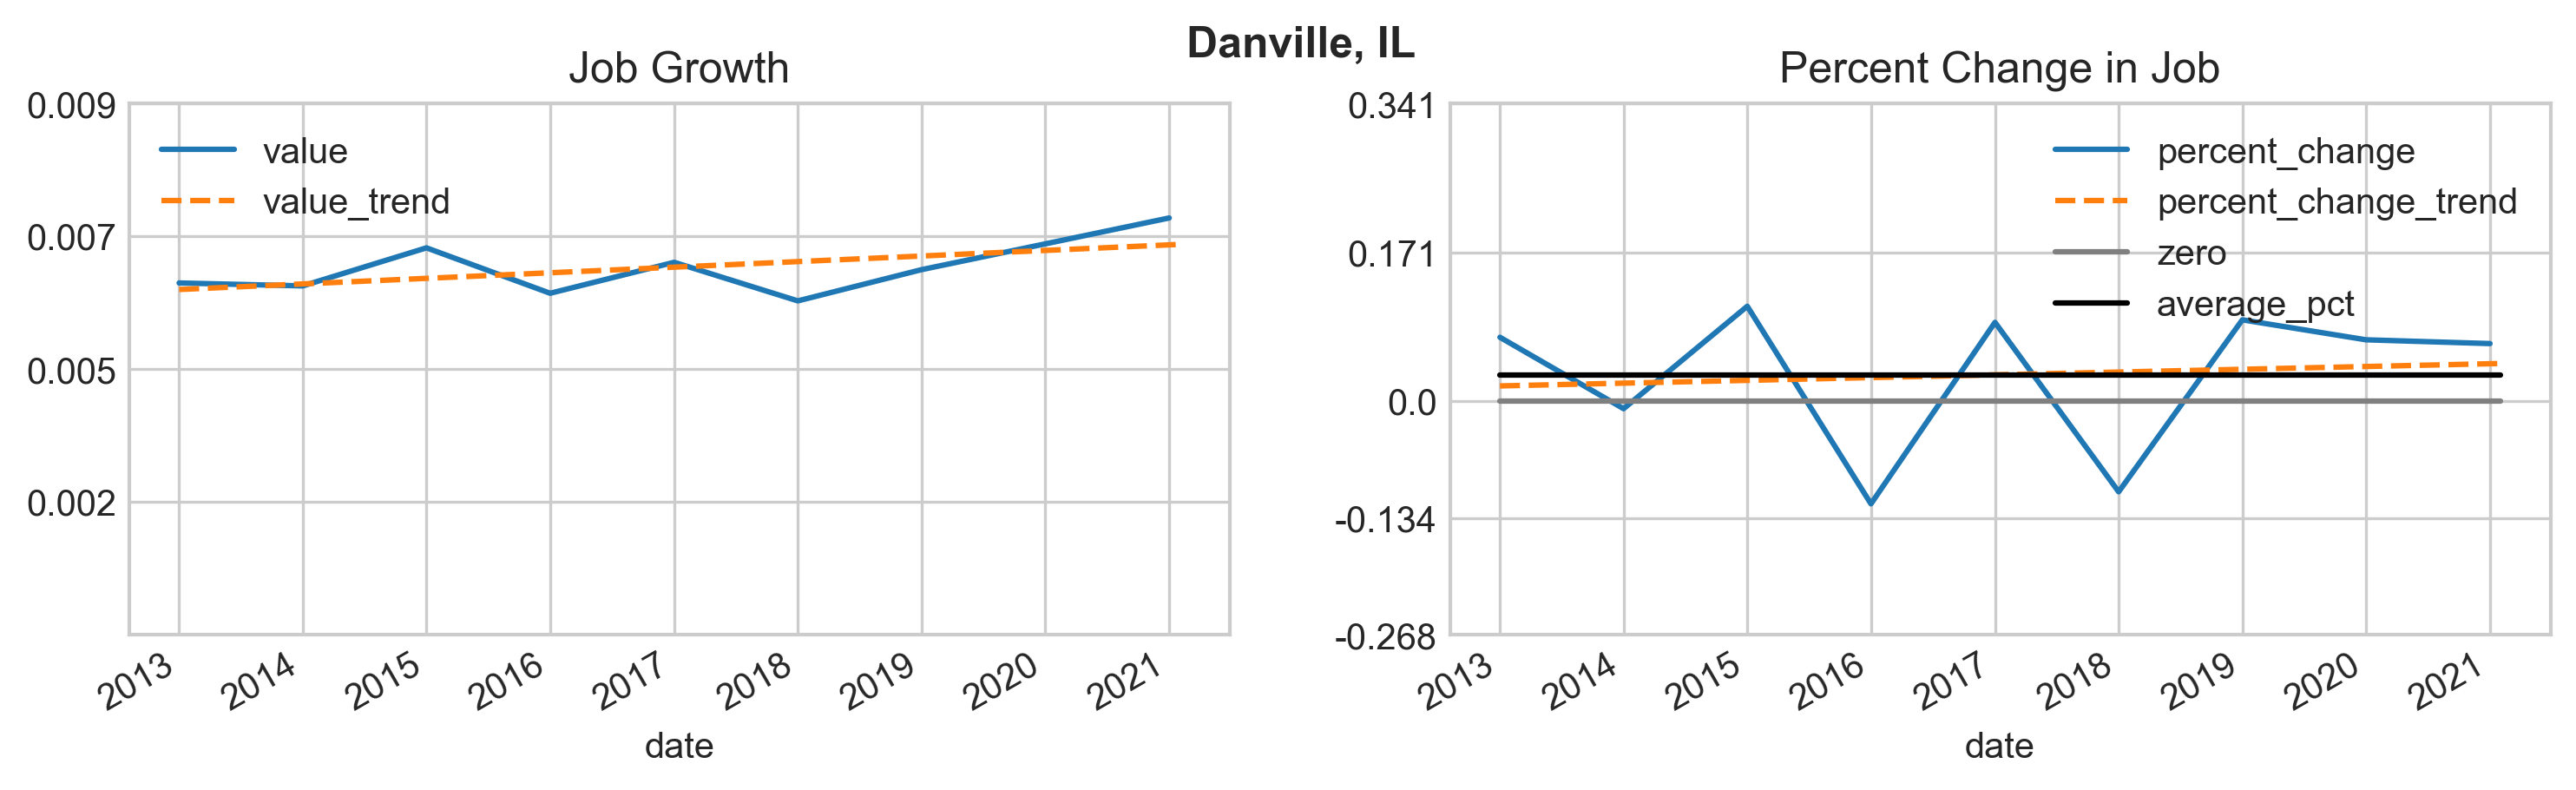

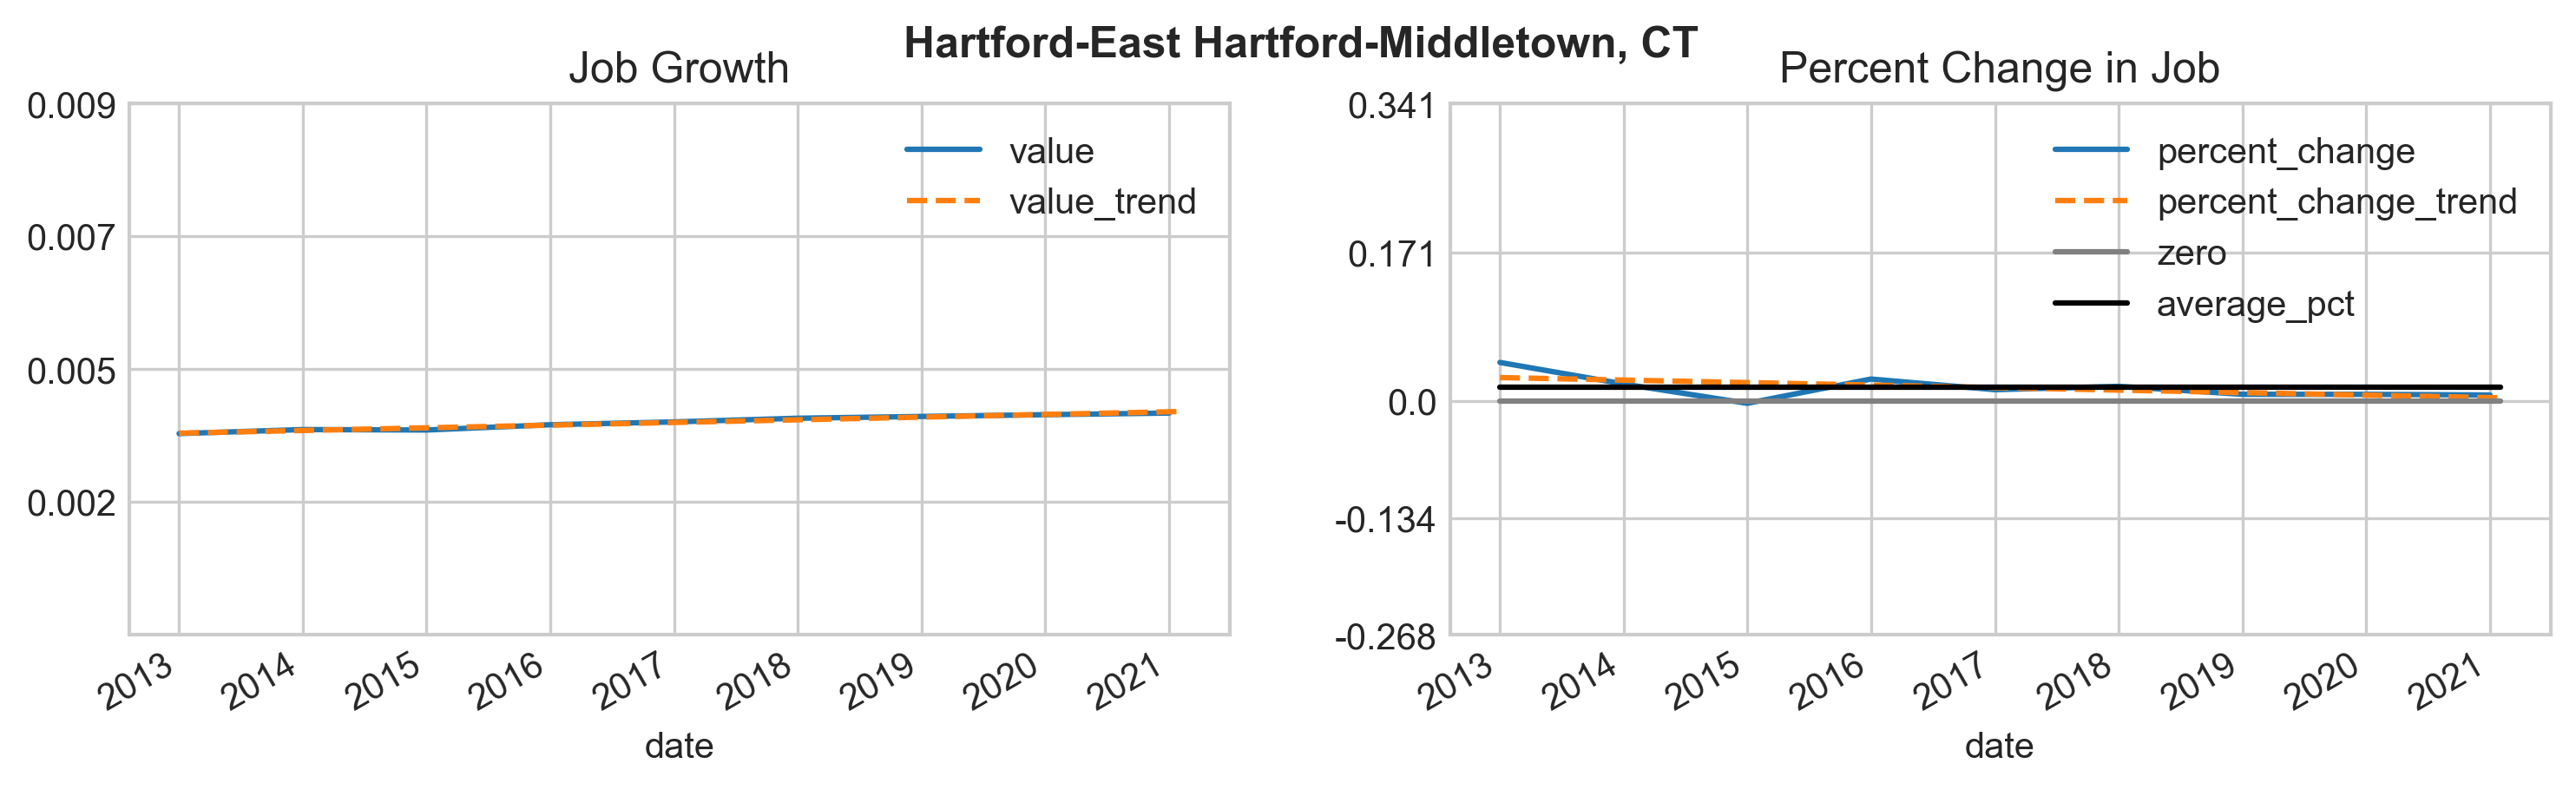

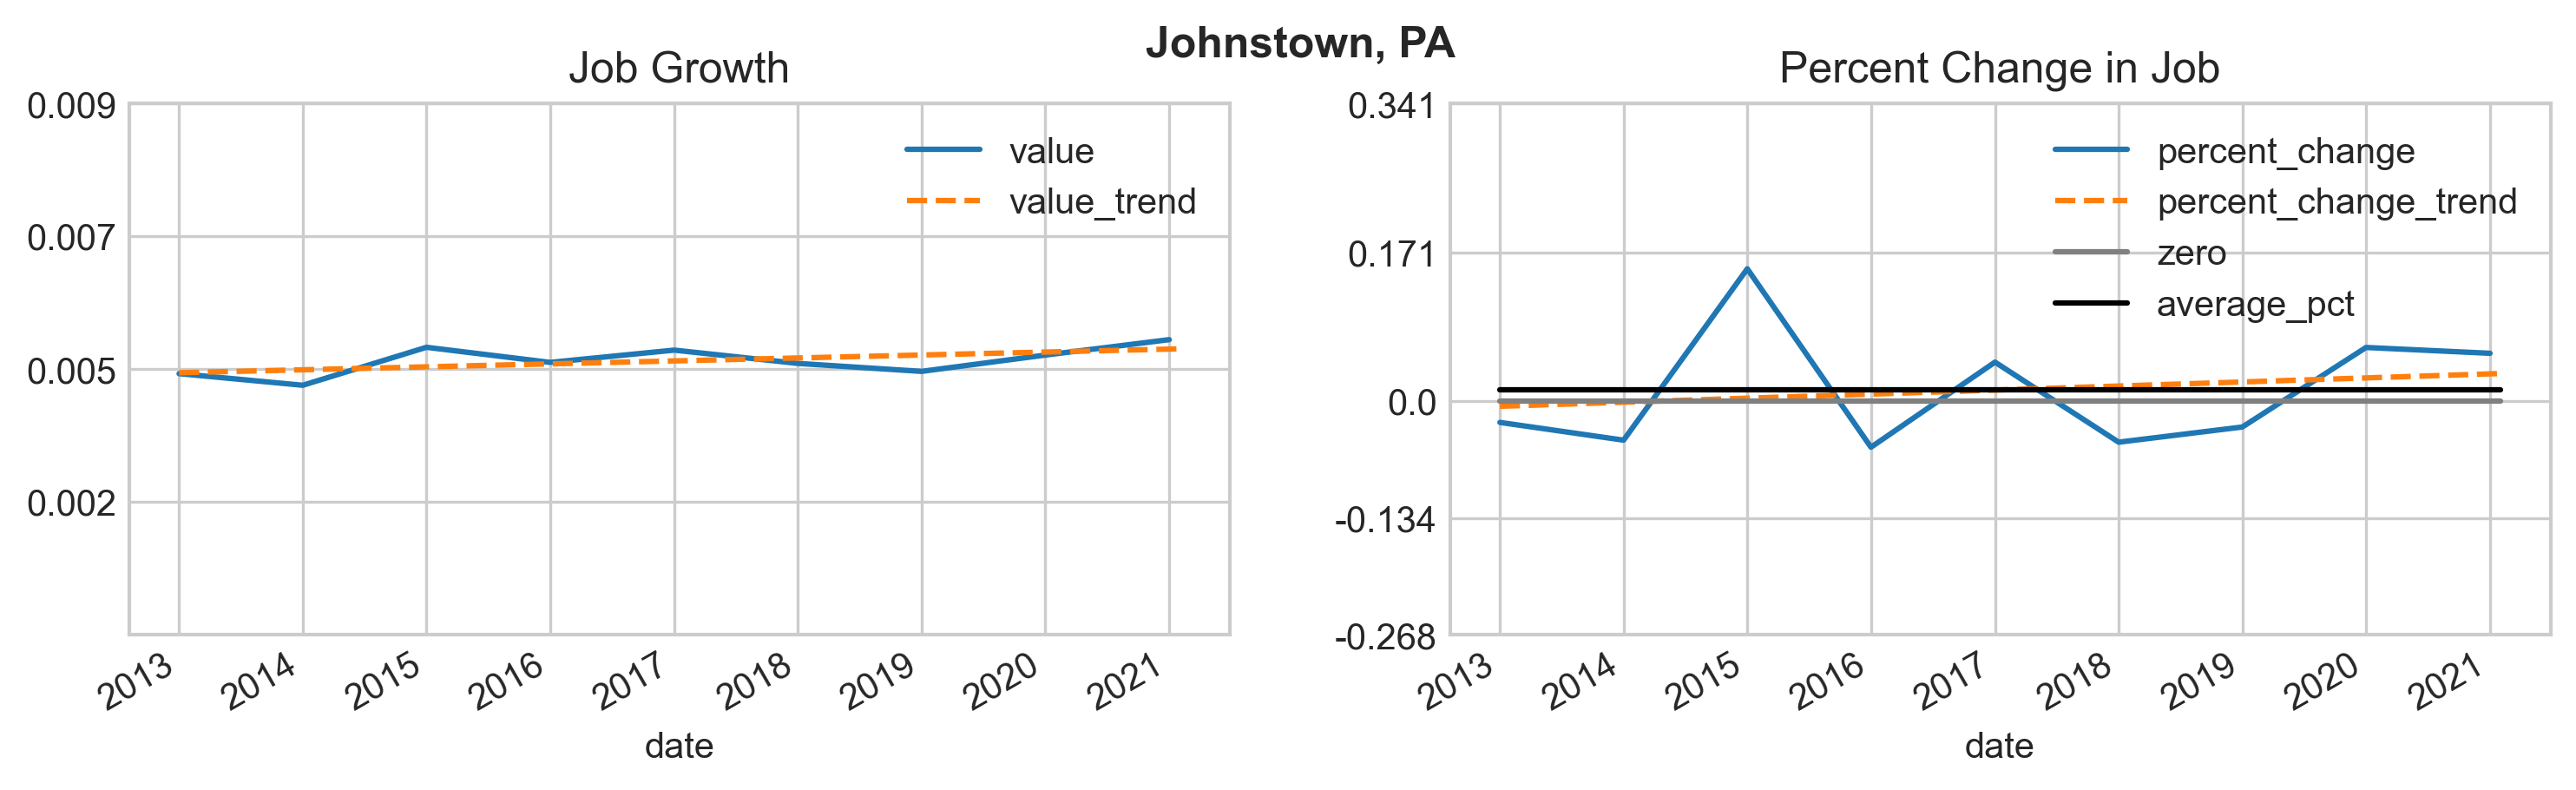

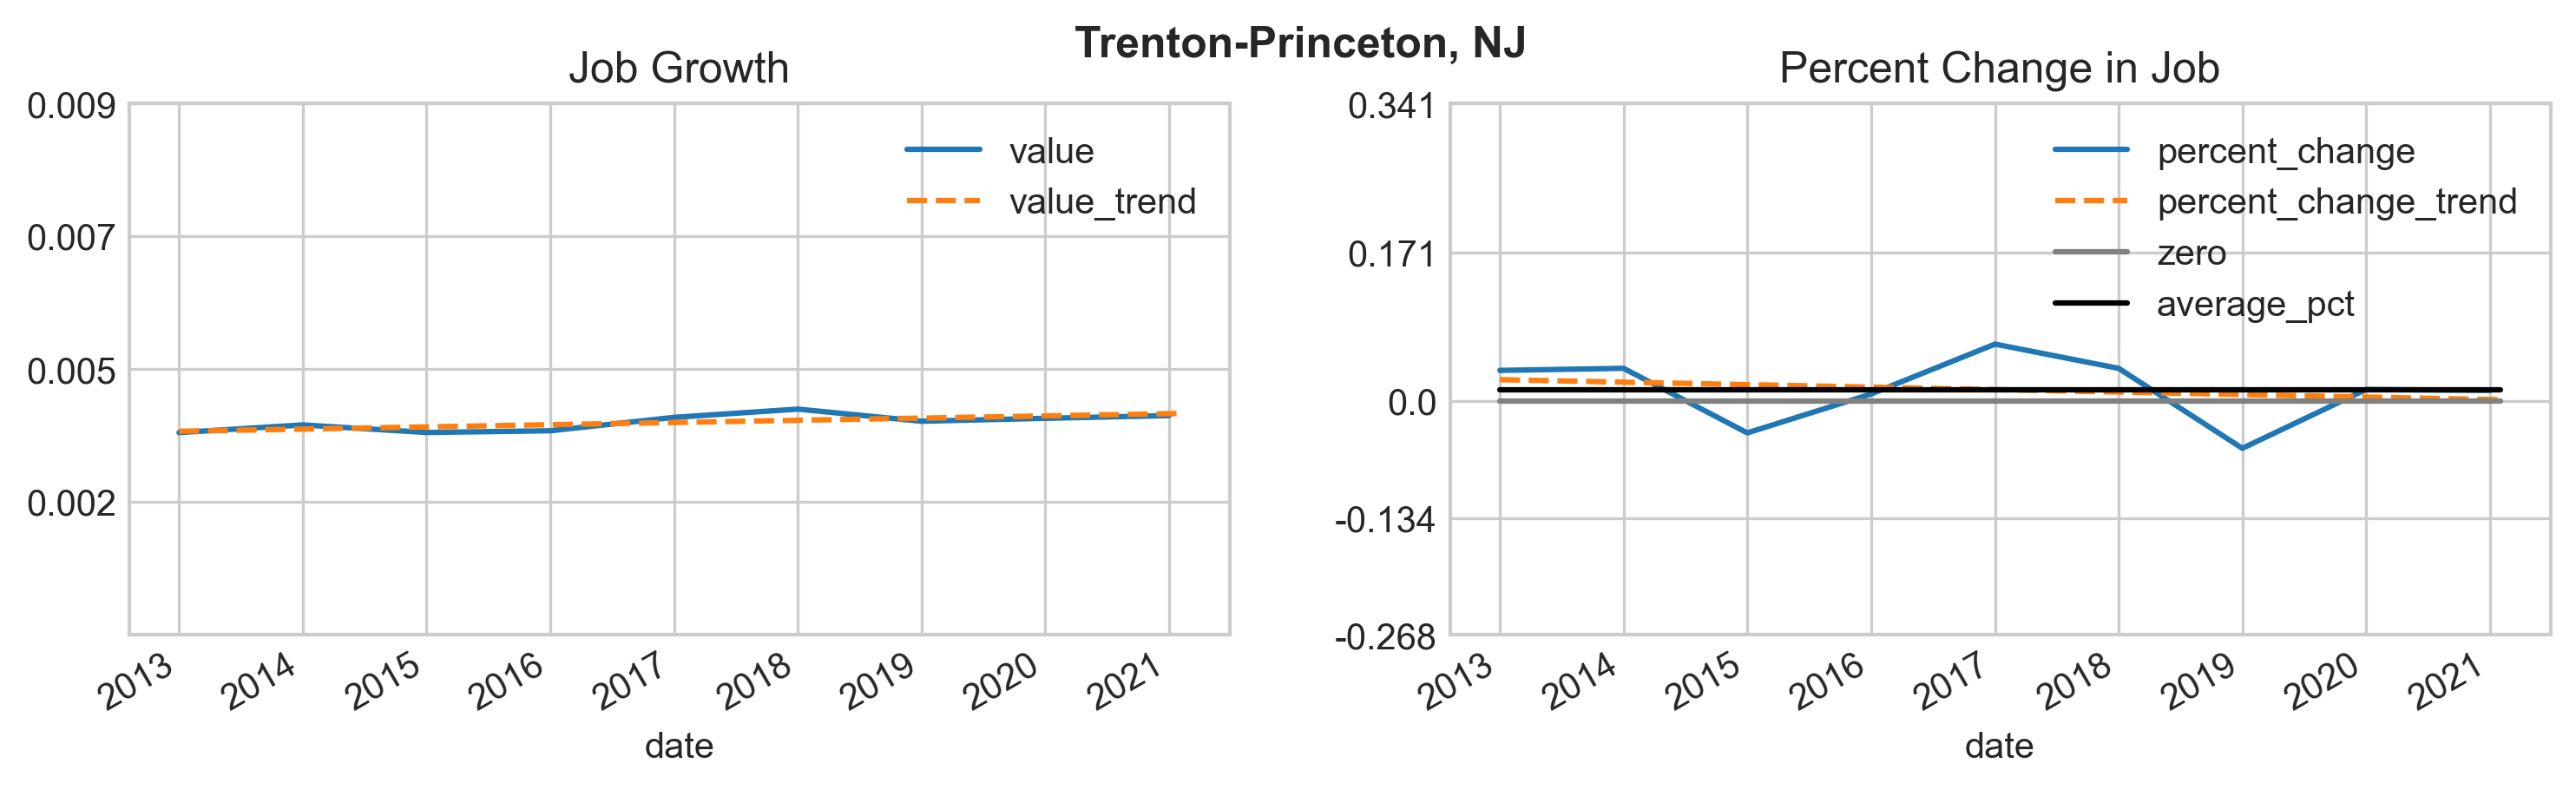

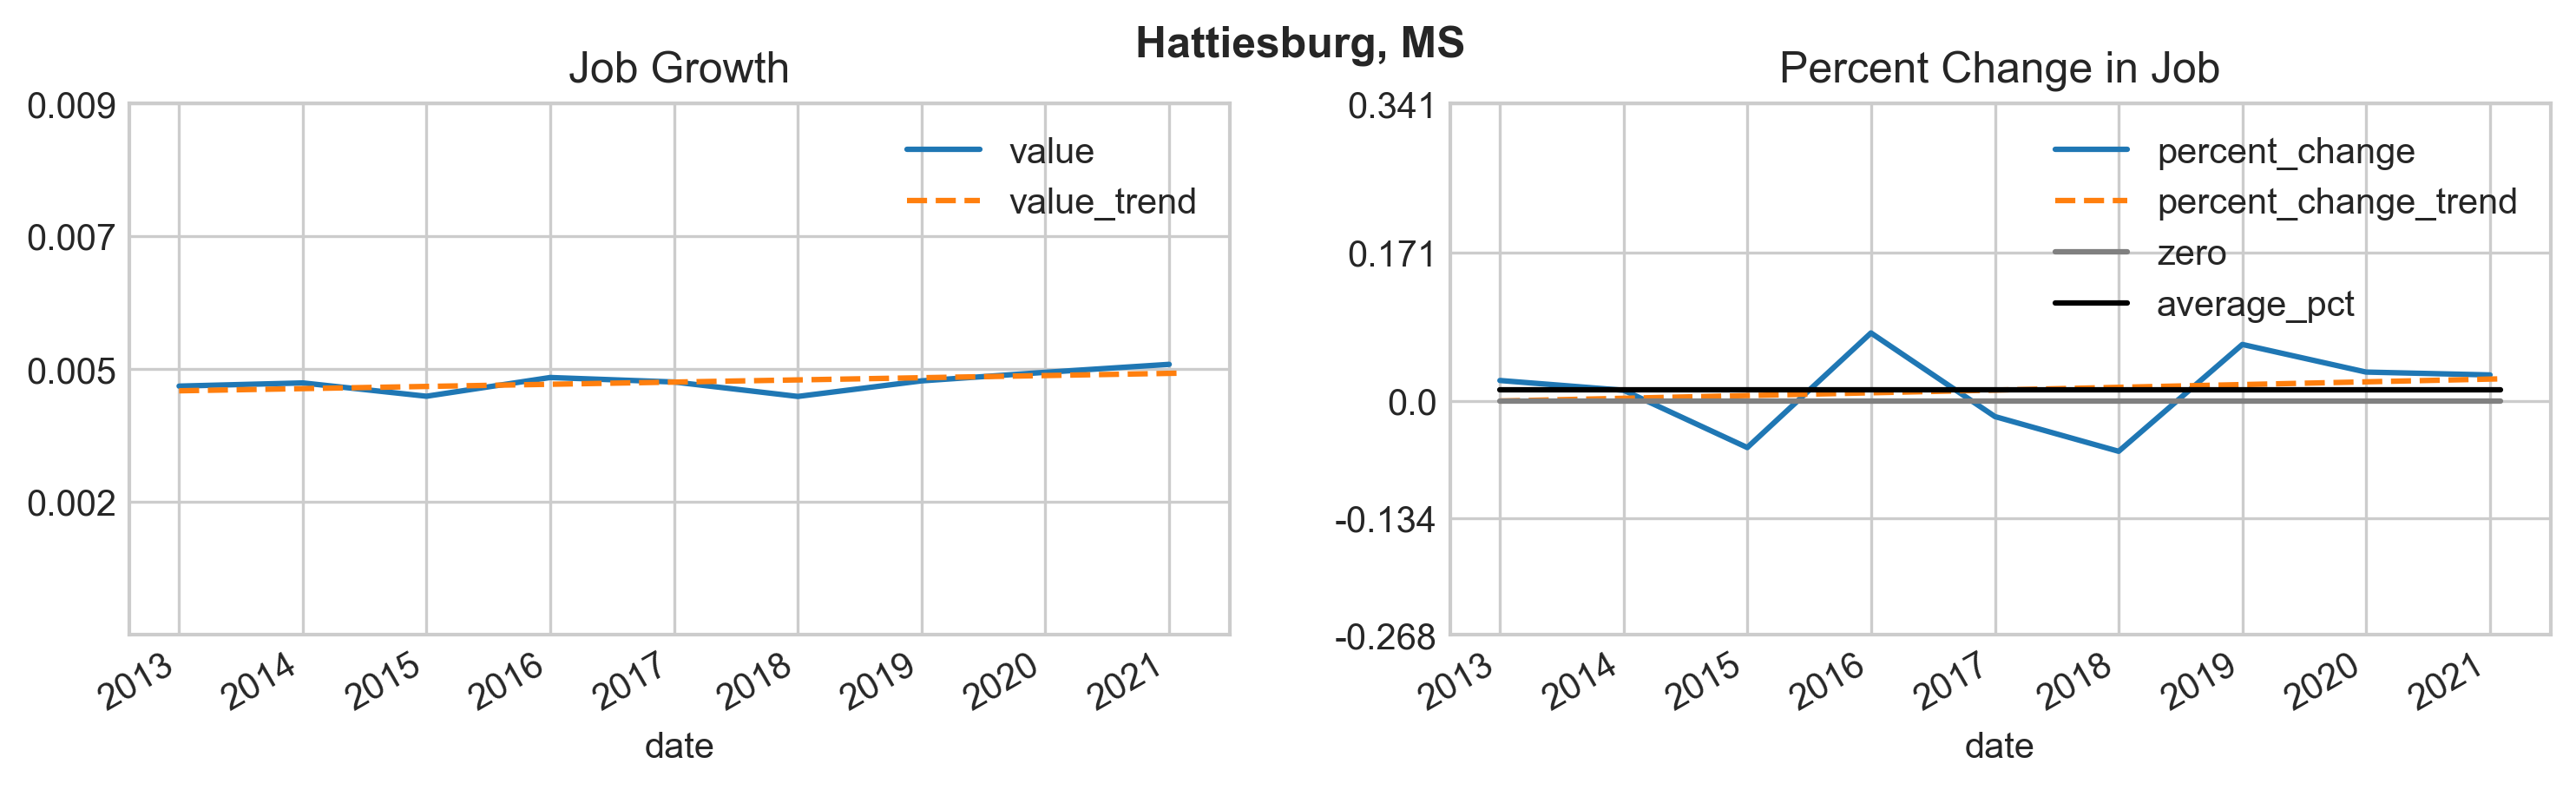

,city,trend_coef,average_value,average_pct,average_pct_rank,trend_coef_rank,total_rank
0,"Danville, IL",0.000000,0.000172,0.030471,0,0,0
1,"Hartford-East Hartford-Middletown, CT",0.000000,0.000056,0.015839,4,2,6
2,"Johnstown, PA",0.000000,0.000053,0.013005,11,1,12
3,"Trenton-Princeton, NJ",0.000000,0.000046,0.013559,7,5,12
4,"Hattiesburg, MS",0.000000,0.000053,0.013014,10,6,16
...,...,...,...,...,...,...,...
375,"Carson City, NV",-0.000001,-0.000263,-0.073503,379,363,742
376,"Lake Havasu City-Kingman, AZ",-0.000001,-0.000263,-0.056597,373,370,743
377,"Merced, CA",-0.000001,-0.000260,-0.063645,378,368,746
378,"Madera, CA",-0.000001,-0.000235,-0.063393,377,372,749


Dropping Dayton-Kettering, OH, it's dataframe has a smaller window.


,msa_name,msa_code,year,value,date,state_code,value_change,percent_change
0,"Dayton-Kettering, OH",19430,2019,0.004609,2019-01-01,39,NaN,NaN
1,"Dayton-Kettering, OH",19430,2020,0.004431,2020-01-01,39,-0.000178,-0.038544
2,"Dayton-Kettering, OH",19430,2021,0.004282,2021-01-01,39,-0.000149,-0.033601


Dropping Enid, OK, it's dataframe has a smaller window.


,msa_name,msa_code,year,value,date,state_code,value_change,percent_change
0,"Enid, OK",21420,2016,0.005514,2016-01-01,40,NaN,NaN
1,"Enid, OK",21420,2017,0.005507,2017-01-01,40,-0.000007,-0.001235
2,"Enid, OK",21420,2018,0.005325,2018-01-01,40,-0.000182,-0.033052
3,"Enid, OK",21420,2019,0.005251,2019-01-01,40,-0.000074,-0.013912
4,"Enid, OK",21420,2020,0.004743,2020-01-01,40,-0.000508,-0.096703
5,"Enid, OK",21420,2021,0.004322,2021-01-01,40,-0.000422,-0.088952


Dropping Poughkeepsie-Newburgh-Middletown, NY, it's dataframe has a smaller window.


,msa_name,msa_code,year,value,date,state_code,value_change,percent_change
0,"Poughkeepsie-Newburgh-Middletown, NY",39100,2019,0.003912,2019-01-01,36,0.000419,0.119798
1,"Poughkeepsie-Newburgh-Middletown, NY",39100,2020,0.003753,2020-01-01,36,-0.000159,-0.040760
2,"Poughkeepsie-Newburgh-Middletown, NY",39100,2021,0.003615,2021-01-01,36,-0.000138,-0.036814


Dropping Prescott Valley-Prescott, AZ, it's dataframe has a smaller window.


,msa_name,msa_code,year,value,date,state_code,value_change,percent_change
0,"Prescott Valley-Prescott, AZ",39150,2019,0.002991,2019-01-01,04,NaN,NaN
1,"Prescott Valley-Prescott, AZ",39150,2020,0.002774,2020-01-01,04,-0.000218,-0.072762
2,"Prescott Valley-Prescott, AZ",39150,2021,0.002600,2021-01-01,04,-0.000174,-0.062557


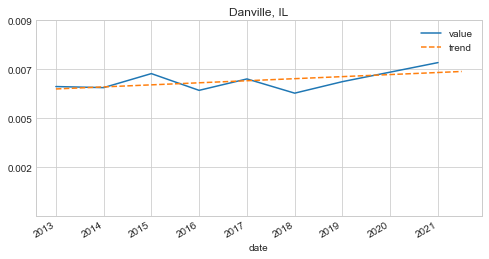

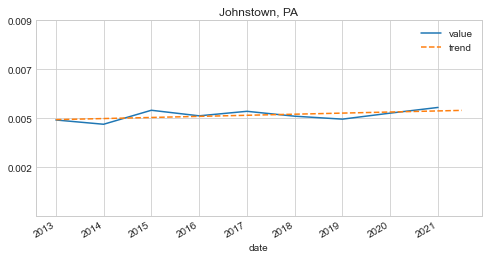

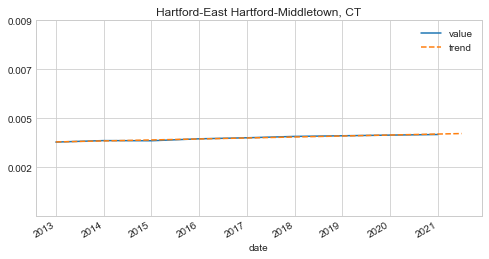

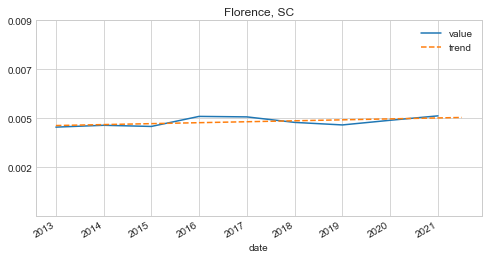

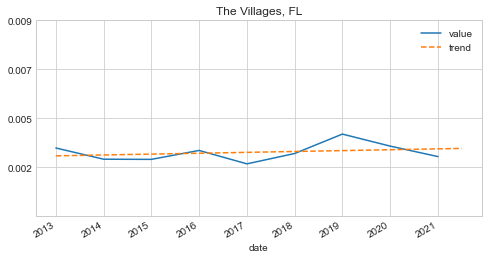

,city,trend_coef,average_value,average_pct
0,"Danville, IL",0.000000,0.000172,0.030471
1,"Johnstown, PA",0.000000,0.000053,0.013005
2,"Hartford-East Hartford-Middletown, CT",0.000000,0.000056,0.015839
3,"Florence, SC",0.000000,0.000033,0.008601
4,"The Villages, FL",0.000000,-0.000056,-0.003738
...,...,...,...,...
375,"Sherman-Denison, TX",-0.000001,-0.000211,-0.043284
376,"Odessa, TX",-0.000001,-0.000147,-0.016252
377,"Lakeland-Winter Haven, FL",-0.000001,-0.000278,-0.048453
378,"Midland, TX",-0.000001,-0.000220,-0.044755


,city,trend_coef,average_value,average_pct
0,"Danville, IL",0.000000,0.000172,0.030471
1,"Johnstown, PA",0.000000,0.000053,0.013005
2,"Hartford-East Hartford-Middletown, CT",0.000000,0.000056,0.015839
3,"Florence, SC",0.000000,0.000033,0.008601
4,"The Villages, FL",0.000000,-0.000056,-0.003738
...,...,...,...,...
375,"Sherman-Denison, TX",-0.000001,-0.000211,-0.043284
376,"Odessa, TX",-0.000001,-0.000147,-0.016252
377,"Lakeland-Winter Haven, FL",-0.000001,-0.000278,-0.048453
378,"Midland, TX",-0.000001,-0.000220,-0.044755


In [499]:
# Plot rent_to_price ratio

rp_coef = plot_top_5_job_cities(
    rent_to_price, sort_by_avg_pct_growth_and_total_trend=True,
    begin_year=2013, demographic="Job"
)

plot_top_5_job_cities(rent_to_price, begin_year=2013, demographic="Job")



In [338]:
jobs

,msa_code,msa_name,state_code,year,month,date,value,series_id
0,10180,"Abilene, TX",48,2022,November,2022-11-01,73500.000000,SMS48101800000000001
1,10180,"Abilene, TX",48,2022,October,2022-10-01,73600.000000,SMS48101800000000001
2,10180,"Abilene, TX",48,2022,September,2022-09-01,73600.000000,SMS48101800000000001
3,10180,"Abilene, TX",48,2022,August,2022-08-01,74300.000000,SMS48101800000000001
4,10180,"Abilene, TX",48,2022,July,2022-07-01,74200.000000,SMS48101800000000001
...,...,...,...,...,...,...,...,...
46405,49740,"Yuma, AZ",04,2013,May,2013-05-01,51800.000000,SMS04497400000000001
46406,49740,"Yuma, AZ",04,2013,April,2013-04-01,51600.000000,SMS04497400000000001
46407,49740,"Yuma, AZ",04,2013,March,2013-03-01,51900.000000,SMS04497400000000001
46408,49740,"Yuma, AZ",04,2013,February,2013-02-01,52000.000000,SMS04497400000000001
